# Анализ столкновений птиц с воздушными судами

Нам предоставлены данные о столкновениях птиц с воздушными судами в аэропортах США за 5 лет (2018-2022) - различная информация, связанная со столкновениями (информация о воздушном судне, аэропорте, погодных условиях). Требуется определить зависимость количества столкновений от погодных факторов (температуры воздуха, направления и силы ветра, точки росы, атмосферного давления) с целью дальнейшего прогнозирования вероятности столкновений.

In [1]:
import requests
import urllib
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
pd.set_option('display.max_columns', None)

## Изучение и предобработка файла столкновений

Сначала придется предобработать данные:
- убрать лишние поля, оставить только необходимые и достаточные для выявления зависимости частоты столкновений с погодными условиями
- убрать строки не отвечающие условиям (не соответсвующая информация, отсутствие ключевой информации)
- пересмотреть каждую колонку на единообразность информации, внести исправления, поставить заглушки
- привести типы
- удалить дубликаты

In [2]:
folder_url = 'https://disk.yandex.ru/d/FkV8m9w_7IKbRg'

strikes_url = 'data_DE_strikes_and_weather.csv'
flights_url = 'flights_data_DE.csv'

st_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(strikes_url)
fl_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(flights_url)

In [3]:
req_st = requests.get(st_url)
h = json.loads(req_st.text)['href']

req_fl = requests.get(fl_url)
g = json.loads(req_fl.text)['href']

In [4]:
strikes = pd.read_csv(h, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

C:\Users\Admin\AppData\Local\Temp\ipykernel_5368\2957406358.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  strikes = pd.read_csv(h, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')
C:\Users\Admin\AppData\Local\Temp\ipykernel_5368\2957406358.py:1: DtypeWarning: Columns (2,91,99) have mixed types. Specify dtype option on import or set low_memory=False.
  strikes = pd.read_csv(h, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')


In [5]:
flights = pd.read_csv(g, sep='|', error_bad_lines=False, comment='#' , encoding='cp1251')

C:\Users\Admin\AppData\Local\Temp\ipykernel_5368\3701851073.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  flights = pd.read_csv(g, sep='|', error_bad_lines=False, comment='#' , encoding='cp1251')


In [6]:
# путь к папке с датасетами на локальной машине
# path = 'H:/yandex_pract/bird_strikes/'
#strikes = pd.read_csv(path + 'data_DE_strikes_and_weather.csv')

In [7]:
strikes.columns = [x.lower() for x in strikes.columns]

In [8]:
strikes.head()

,п»їcolumn1,index_nr,incident_date,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude_x,longitude_x,runway,state,faaregion,location,opid,operator,reg,flt,aircraft,ama,amo,ema,emo,ac_class,ac_mass,type_eng,num_engs,eng_1_pos,eng_2_pos,eng_3_pos,eng_4_pos,phase_of_flight,height,speed,distance,sky,precipitation,aos,cost_repairs,cost_other,cost_repairs_infl_adj,cost_other_infl_adj,ingested_other,indicated_damage,damage_level,str_rad,dam_rad,str_windshld,dam_windshld,str_nose,dam_nose,str_eng1,dam_eng1,ing_eng1,str_eng2,dam_eng2,ing_eng2,str_eng3,dam_eng3,ing_eng3,str_eng4,dam_eng4,ing_eng4,str_prop,dam_prop,str_wing_rot,dam_wing_rot,str_fuse,dam_fuse,str_lg,dam_lg,str_tail,dam_tail,str_lghts,dam_lghts,str_other,dam_other,other_specify,effect,effect_other,bird_band_number,species_id,species,remarks,remains_collected,remains_sent,warned,num_seen,num_struck,size,enroute_state,nr_injuries,nr_fatalities,comments,reported_name,reported_title,source_x,person,lupdate,transfer,unnamed: 0,id,station,date,source_y,latitude_y,longitude_y,elevation,name,report_type,call_sign,quality_control,wnd,cig,vis,tmp,dew,slp
0,0,802071,2018-01-06 00:00:00.000,1,2018,NaN,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.03720,17C,TX,ASW,NaN,ENY,ENVOY AIR,N234JW,3631,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Approach,300.0,133.0,NaN,No Cloud,NaN,1.0,NaN,100.0,NaN,117.0,False,False,N,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,UNKBS,Unknown bird - small,Short final about 300 ft runway 17C at DFW. on...,True,False,Unknown,2-10,2-10,Small,NaN,NaN,NaN,"2018-1-6-094630,2018-1-6-091820 /Legacy Record...",REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,2018-06-30 00:00:00.000,False,183.0,802071.0,72259003927,2018-01-06 12:00:00,4,32.89780,-97.01890,170.7,"DAL FTW WSCMO AIRPORT, TX US",FM-12,99999,V020,"150,1,N,0021,1","22000,1,9,N","016000,1,9,9","+0028,1","-0011,1","10253,1"
1,1,802074,2018-01-22 00:00:00.000,1,2018,NaN,NaN,KIAH,GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT,29.98047,-95.33972,TWY EE,TX,ASW,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,N5111,Killdeer,"DAY, 1516.",True,False,Unknown,NaN,1,Small,NaN,NaN,NaN,2018-1-22-171957 /Legacy Record=401276/,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2018-06-30 00:00:00.000,False,744.0,802074.0,72243012960,2018-01-22 12:00:00,4,29.98000,-95.36000,29.0,"HOUSTON INTERCONTINENTAL AIRPORT, TX US",FM-12,99999,V020,"300,1,N,0026,1","22000,1,9,N","016000,1,9,9","+0161,1","+0089,1","10144,1"
2,2,802081,2018-01-09 00:00:00.000,1,2018,12:57,Day,KTEB,TETERBORO AIRPORT,40.85010,-74.06084,24,NJ,AEA,NaN,BUS,BUSINESS,N679MS,972,EMB-500 PHENOM 100,332,NaN,31.0,NaN,A,2.0,D,2.0,5.0,5.0,NaN,NaN,Approach,NaN,NaN,2.0,Some Cloud,NaN,NaN,NaN,NaN,NaN,NaN,False,False,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,PART NOT REPTD,NaN,NaN,NaN,UNKB,Unknown bird,Pilot reported to Teterboro Tower striking a b...,False,False,Yes,1,1,NaN,NaN,NaN,NaN,"2018-1-10-074748, EXEAIRE /Legacy Record=401283/",REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,2018-06-30 00:00:00.000,False,237.0,802081.0,72502594741,2018-01-09 13:51:00,7,40.85000,-74.06139,2.7,"TETERBORO AIRPORT, NJ US",FM-15,KTEB,V020,"260,5,N,0046,5","22000,5,9,N","016093,5,N,5","+0011,5","-0039,5","10210,5"
3,3,802082,2018-01-10 00:00:00.000,1,2018,NaN,NaN,KPGD,PUNTA GORDA ARPT,26.92019,-81.99053,4,FL,ASO,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,N

In [9]:
strikes.info(max_cols=120)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86872 entries, 0 to 86871
Data columns (total 119 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    п»їcolumn1             86872 non-null  int64  
 1    index_nr               86872 non-null  int64  
 2    incident_date          86872 non-null  object 
 3    incident_month         86872 non-null  int64  
 4    incident_year          86872 non-null  int64  
 5    time                   71030 non-null  object 
 6    time_of_day            42590 non-null  object 
 7    airport_id             86869 non-null  object 
 8    airport                86872 non-null  object 
 9    latitude_x             74644 non-null  float64
 10   longitude_x            74643 non-null  float64
 11   runway                 66450 non-null  object 
 12   state                  74644 non-null  object 
 13   faaregion              74644 non-null  object 
 14   location               12062 non-nul

In [10]:
# оставим только те столбцы, которые нам могут потребоваться в данном исследовании
strikes = strikes[['incident_date','incident_month','incident_year','time','time_of_day',
                   'airport_id','airport','latitude_x','longitude_x','state','faaregion','location',
                   'phase_of_flight','height','speed','distance','sky','precipitation','species_id','species',
                   'remarks','enroute_state','comments','wnd','cig','vis','tmp','dew','slp',]]

In [11]:
# удаляем явные дубликаты
strikes = strikes.drop_duplicates()
print('количество строк', len(strikes))

количество строк 86796


In [12]:
# переименуем поля
strikes = strikes.rename(columns={'incident_date':'date', 'incident_month':'month', 'incident_year':'year',
                                 'latitude_x':'latitude','longitude_x':'longitude'})

In [13]:
# переведем время в формат datetime
strikes['date'] = strikes['date'].apply(lambda x: pd.to_timedelta(int(x), unit='D') + 
                                                  pd.to_datetime('1899-12-30 00:00:00', format='%Y-%m-%d %H:%M:%S') 
                                        if len(str(x)) == 5 else pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f'))

In [14]:
# в столбце time оставим целые часы
# удаляем символ % и добавляем 0 в конец
strikes['time'] = np.where(strikes['time'].str[0] == '%', strikes['time'].str[1:] + '0', strikes['time'])
# добавляем 0 перед часом, записанным одной цифрой - все часы должны быть записаны двумя цифрами
strikes['time'] = np.where(strikes['time'].str[1] == ':', '0' + strikes['time'].str[:], strikes['time'])
# перевод из 12 часового обозначения в 24 часовое - там где присутствует PM прибавляем к часам 12
strikes['time'] = np.where(strikes['time'].str[-2] == 'P', strikes['time'].str[:2].astype(float) + 12, strikes['time'])
# оставляем целые часы - два первых символа
strikes['time'] = strikes['time'].str[:2]
# меняем 24 на 00 (возможно, в этих строках дата станет неверной, т.е. надо прибавить сутки, но таких строк мало)
strikes['time'] = strikes['time'].replace('24', '00')

# заполняем пропуски 99
strikes['time'] = strikes['time'].fillna(99)
# переводим в int
strikes['time'] = strikes['time'].astype(int)

In [15]:
# удалим лишние строки с неизвестными аэропортами
strikes = strikes.dropna(subset=['airport_id'])
print('количество строк', len(strikes))

количество строк 86793


In [16]:
# удалим все записи, где отсутствует какая-либо информация о погоде
# информация о погоде содержится в поле sky и серии композитных полей: wnd, cig, vis, tmp, dew, slp
strikes = strikes[(strikes['sky'].notna()) | strikes['wnd'].notna()]
print('количество строк', len(strikes))

количество строк 75821


In [17]:
# в столбце 'location' указан аэропорт обнаружения повреждение от попадания птицы с неизвестным моментом и местом происшествия
# удалим все записи, в которых это поле заполнено
strikes = strikes[strikes['location'].isna()]

# затем удалим поле 'location', оно больше не понадобится
strikes = strikes[['date','month','year','time','time_of_day','airport_id','airport','latitude',
'longitude','state','faaregion','phase_of_flight','height','speed','distance','sky','precipitation',
'species_id','species','remarks','enroute_state','comments','wnd','cig','vis','tmp','dew','slp']]
print('количество строк', len(strikes))

количество строк 74407


In [18]:
# убираем столкновения с млекопитающими (код начинается на 1), рептилиями (код начинется на 2)
strikes = strikes[(strikes['species_id'].str[0] != '1') & (strikes['species_id'].str[0] != '2')]
print('количество строк', len(strikes))

количество строк 70445


In [19]:
# выделяем важные погодные факторы из композитных полей wnd, cig, vis, tmp, dew, slp

strikes['wind_direction'] = strikes['wnd'].str.split(',', expand=True)[0] # направление ветра
strikes['wind_bofort'] = strikes['wnd'].str.split(',', expand=True)[2] # характер ветра по шкале Бофорта
strikes['wind_speed'] = strikes['wnd'].str.split(',', expand=True)[3] # скорость ветра

strikes['vertical_visibility'] = strikes['cig'].str.split(',', expand=True)[0] # вертикальная видимость
strikes['check'] = strikes['cig'].str.split(',', expand=True)[3] # зарегистрировано ли состояние "потолок и видимость в норме"
strikes['horizontal_visibility'] = strikes['vis'].str.split(',', expand=True)[0] # горизонтальная видимость

strikes['temperature'] = strikes['tmp'].str.split(',', expand=True)[0] # температура воздуха
strikes['dew_point'] = strikes['dew'].str.split(',', expand=True)[0] # температура - точка росы
strikes['pressure'] = strikes['slp'].str.split(',', expand=True)[0] # атмосферное давление

In [20]:
# переведем значения погодных измерений в вещественные с целью сравнения
strikes['wind_direction'] = pd.to_numeric(strikes['wind_direction'], errors='raise')
strikes['wind_speed'] = pd.to_numeric(strikes['wind_speed'], errors='raise') / 10
strikes['vertical_visibility'] = pd.to_numeric(strikes['vertical_visibility'], errors='raise')
strikes['horizontal_visibility'] = pd.to_numeric(strikes['horizontal_visibility'], errors='raise')
strikes['temperature'] = pd.to_numeric(strikes['temperature'], errors='raise') / 10
strikes['dew_point'] = pd.to_numeric(strikes['dew_point'], errors='raise') / 10
strikes['pressure'] = pd.to_numeric(strikes['pressure'], errors='raise')

In [21]:
# убираем композитные поля
strikes = strikes[['date','month','year','time','time_of_day','airport_id','airport','latitude',
'longitude','state','faaregion','phase_of_flight','height','speed','distance','sky','precipitation',
'species_id','species','remarks','enroute_state','comments','wind_direction','wind_bofort','wind_speed', 
'vertical_visibility','check','horizontal_visibility','temperature','dew_point','pressure']]

In [22]:
# заполняем пропуски в новых колонках в соответствии с регламентом заполнения пропусков в документе ISD
#strikes['wind_direction'] = strikes['wind_direction'].fillna(999)
#strikes['wind_bofort'] = strikes['wind_bofort'].fillna(9)
#strikes['wind_speed'] = strikes['wind_speed'].fillna(9999)
#strikes['vertical_visibility'] = strikes['vertical_visibility'].fillna(99999)
#strikes['check'] = strikes['check'].fillna(9)
#strikes['horizontal_visibility'] = strikes['horizontal_visibility'].fillna(999999)
#strikes['temperature'] = strikes['temperature'].fillna(9999)
#strikes['dew_point'] = strikes['dew_point'].fillna(9999)
#strikes['pressure'] = strikes['pressure'].fillna(99999)

In [23]:
# меняем неопределенные значение на NAN 
strikes['wind_speed'] = np.where(strikes['wind_speed'] == 9999, np.nan, strikes['wind_speed'])
strikes['vertical_visibility'] = np.where(strikes['vertical_visibility'] == 99999, np.nan, strikes['vertical_visibility'])
strikes['horizontal_visibility'] = np.where(strikes['horizontal_visibility'] == 999999, np.nan, strikes['horizontal_visibility'])
strikes['temperature'] = np.where(strikes['temperature'] == 9999, np.nan, strikes['temperature'])
strikes['dew_point'] = np.where(strikes['dew_point'] == 9999, np.nan, strikes['dew_point'])
strikes['pressure'] = np.where(strikes['pressure'] == 99999, np.nan, strikes['pressure'])

In [24]:
strikes = strikes[(strikes['year'] >= 2018) & (strikes['year'] <= 2022)]

In [25]:
# уникальные значения времени суток
strikes['time_of_day'].unique()

array([nan, 'Day', 'Night', 'Dusk', 'Dawn'], dtype=object)

In [26]:
# час суток, встречающийся в значении времени суток
strikes[strikes['time_of_day'] == 'Dawn']['time'].unique()

array([99,  7,  6,  5,  3, 11,  4,  9,  8, 19, 16,  0, 10, 17, 22,  2, 13,
       12, 14, 15, 18,  1])

Наблюдатся явное несоответствие колонок time и time_of_date - требуется выяснить, какой колонке стоит больше доверять

In [27]:
strikes.groupby('time_of_day').agg({'date':'count'})

,date
time_of_day,
Dawn,1428
Day,22167
Dusk,1775
Night,10019


далее будем доверять колонке time

**Получили таблицу strikes с уменьшенным количеством полей, готовую к анализу**

Описание полей таблицы strikes:
- date - дата столкновения
- month - месяц столкновения
- year - год столкновения
- time - время столкновения (целые часы)
- time_of_day - время дня
- airport_id - код аэропорта
- airport - название аэропорта 
- latitude - широта аэропорта
- longitude - долгота аэропорта
- state - штат
- faaregion - регион
- phase_of_flight - фаза полета
- height - высота столкновения
- speed - скорость самолета при столкновении
- distance - расстояние от аэропорта
- sky - состояние неба (похожая информация содержится в полях vertical_visibility, horizontal_visibility и check)
- precipitation - осадки
- species_id - код типа птицы
- species - название птицы
- remarks - примечания по существу или при вводе данных
- enroute_state - местоположение на маршруте
- comments - комментарии менеджера базы данных
- wind_direction - направление ветра
- wind_bofort - характер ветра по шкале Бофорта
- wind_speed - скорость ветра (метры в секунду)
- vertical_visibility - вертикальная видимость - расстояние от земли до ближайших облаков, закрывающих 5/8 неба (метры) 99999 - не определено
- check - зарегистрировано ли состояние "потолок и видимость в норме"
- horizontal_visibility - видимость (метры) 999999 - не определено
- temperature - температура воздуха (градусы С), 9999 - не определена
- dew_point - температура, точка росы (градусы С)
- pressure - атмосферное давление (гектопаскали)

In [28]:
strikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63341 entries, 0 to 86871
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   63341 non-null  datetime64[ns]
 1   month                  63341 non-null  int64         
 2   year                   63341 non-null  int64         
 3   time                   63341 non-null  int32         
 4   time_of_day            35389 non-null  object        
 5   airport_id             63341 non-null  object        
 6   airport                63341 non-null  object        
 7   latitude               63253 non-null  float64       
 8   longitude              63253 non-null  float64       
 9   state                  63253 non-null  object        
 10  faaregion              63253 non-null  object        
 11  phase_of_flight        39398 non-null  object        
 12  height                 30107 non-null  float64       
 13  s

In [29]:
strikes.head(3)

,date,month,year,time,time_of_day,airport_id,airport,latitude,longitude,state,faaregion,phase_of_flight,height,speed,distance,sky,precipitation,species_id,species,remarks,enroute_state,comments,wind_direction,wind_bofort,wind_speed,vertical_visibility,check,horizontal_visibility,temperature,dew_point,pressure
0,2018-01-06,1,2018,99,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.03720,TX,ASW,Approach,300.0,133.0,NaN,No Cloud,NaN,UNKBS,Unknown bird - small,Short final about 300 ft runway 17C at DFW. on...,NaN,"2018-1-6-094630,2018-1-6-091820 /Legacy Record...",150.0,N,2.1,22000.0,N,16000.0,2.8,-1.1,10253.0
1,2018-01-22,1,2018,99,NaN,KIAH,GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT,29.98047,-95.33972,TX,ASW,NaN,NaN,NaN,0.0,NaN,NaN,N5111,Killdeer,"DAY, 1516.",NaN,2018-1-22-171957 /Legacy Record=401276/,300.0,N,2.6,22000.0,N,16000.0,16.1,8.9,10144.0
2,2018-01-09,1,2018,12,Day,KTEB,TETERBORO AIRPORT,40.85010,-74.06084,NJ,AEA,Approach,NaN,NaN,2.0,Some Cloud,NaN,UNKB,Unknown bird,Pilot reported to Teterboro Tower striking a b...,NaN,"2018-1-10-074748, EXEAIRE /Legacy Record=401283/",260.0,N,4.6,22000.0,N,16093.0,1.1,-3.9,10210.0


## Выявление аэропортов с максимальным числом происшествий, изучение информации о загрузке аэропортов

Каждый аэропорт имеет уникальное расположение. Множество факторов влияет на вероятность столкновения с птицами.
Предположение: одна и та же погода в разных аэропортах может быть причиной повышенной или пониженной вероятности столкновения с птицами (исключение составляют экстремальные погодные условия, когда никакие птицы нигде не летают). Поэтому некорректно искать зависимость во всех аэропортах сразу, так мы выявим только экстремальные очевидные явления (например, ночью при температуре ниже -40С и ветре свыше 30м/с столкновения с птицами маловероятны).

Поэтому мы ограничим область исследования аэропортами с наибольшим количеством происшествий и будем сравнивать погодные условия в моменты повышенной частоты происшествий

Изучим отдельно несколько аэропортов, по которым в датасете присутствует много присшествий, как абсолютное, так и относительное

In [30]:
# TOP-10 аэропортов с максимальным числом происшествий (2018-2023)
top_10_airports = strikes.groupby('airport_id', as_index=False).agg({'date':'count', 
                                   'airport':'first',
                                   'state':'first', 
                                   'faaregion':'first'}).sort_values(by='date', ascending=False).head(10)
# список ТОП аэропортов по убыванию количества происшествий
top_10_list = list(top_10_airports['airport_id'])

In [31]:
# оставим в файле столкновений только эти аэропорты
strikes = strikes.query('airport_id in @top_10_list')
print('количество строк', len(strikes))

количество строк 12993


In [32]:
# в файле столкновений группируем данные по аэропорту, году и месяцу
# вычисляем медианные погодные данные для каждого месяца
strikes_by_month = strikes.groupby(['airport_id', 'month', 'year'], as_index=False) \
                          .agg({'date':'count',
                                'wind_speed':'median', 'vertical_visibility':'median','horizontal_visibility':'median',
                                'temperature':'median', 'dew_point':'median', 'pressure':'median'})

In [33]:
# файл с количеством рейсов
#flights = pd.read_csv(path + 'flights_data_DE.csv', sep='|')
flights.columns = [x.lower() for x in flights.columns]

# убираем строки с итогами за год
flights = flights[flights['month'] != 'TOTAL']

# переводим месяцы в целые числа
flights['year'] = flights['year'].astype('int')
flights['month'] = flights['month'].astype('int')

# убираем неявные дубликаты
flights = flights[flights['direction'] == 'Origin']

# добавляем букву К в код аэропорта
flights['airport'] = 'K' + flights['airport'].astype('str')

# переименуем столбец, чтобы не запутаться
flights = flights.rename(columns={'airport':'airport_id'})

# оставляем ТОП-10 аэропортов
flights = flights.query('airport_id in @top_10_list')

# заполняем пропуски
flights['international'] = flights['international'].fillna(0)

# оставляем информацию 2018 - 2023
flights = flights[(flights['year'] >= 2018) & (flights['year'] <= 2022)]

In [34]:
# соединяем таблицу рейсов со сгруппированной таблицей столкновений по аэропорту, году и месяцу
top_airports = flights.merge(strikes_by_month, how='left', left_on=['airport_id','year','month'],
                                right_on=['airport_id','year','month'])
# оставляем нужные столбцы
#top_airports = top_airports[['airport_id', 'year', 'month', 'total','date']]

# даем колонкам новые имена
top_airports = top_airports.rename(columns={'total':'flights','date':'strikes'})

# заполняем нулями пропуски там, где не было столкновений и переводим в целые числа
top_airports['strikes'] = top_airports['strikes'].fillna(0).astype('int')
# добавляем столбец с количеством столкновений на 100тыс рейсов (тысячная доля процента)
top_airports['strikes_by_100000'] = ((top_airports['strikes'] / top_airports['flights']) * 100000).round(1)

top_airports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   600 non-null    int32  
 1   month                  600 non-null    int32  
 2   domestic               600 non-null    float64
 3   international          600 non-null    float64
 4   flights                600 non-null    int64  
 5   airport_id             600 non-null    object 
 6   direction              600 non-null    object 
 7   strikes                600 non-null    int32  
 8   wind_speed             594 non-null    float64
 9   vertical_visibility    589 non-null    float64
 10  horizontal_visibility  594 non-null    float64
 11  temperature            594 non-null    float64
 12  dew_point              594 non-null    float64
 13  pressure               593 non-null    float64
 14  strikes_by_100000      600 non-null    float64
dtypes: flo

In [35]:
# добавим столбец с объединенным месяцем и годом в формате datetime
top_airports['date'] = pd.to_datetime(top_airports['year'].astype(str) + '-' + 
                                      ('0' + top_airports['month'].astype(str)).str[-2:], format='%Y-%m')
# оставим необходимые столбцы и поменяем порядок
top_airports = top_airports[['airport_id','year','month','date',
                             'flights','strikes','strikes_by_100000',
                             'wind_speed','vertical_visibility','horizontal_visibility',
                             'temperature','dew_point','pressure']]
top_airports.head()

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
0,KDEN,2018,1,2018-01-01,21989,7,31.8,3.35,22000.0,16093.0,1.95,-8.05,10257.5
1,KDEN,2018,2,2018-02-01,19735,3,15.2,4.60,22000.0,16093.0,-7.80,-15.00,10127.5
2,KDEN,2018,3,2018-03-01,23114,18,77.9,4.60,22000.0,16046.5,3.90,-4.40,10132.0
3,KDEN,2018,4,2018-04-01,22746,28,123.1,4.60,22000.0,16000.0,6.65,-2.50,10081.0
4,KDEN,2018,5,2018-05-01,23807,53,222.6,3.60,6706.0,16000.0,11.70,6.70,10107.0


Получили таблицу top_airports - в ней содержится информация о 10 аэропортах с максимальным числом происшествий с разбивкой на месяцы и годы.
- количество полетов, 
- количество происшествий, 
- количество происшествий на 100тыс рейсов
- скорость ветра (медиана)
- вертикальная видимость (медиана)
- горизонтальная видимость (медиана)
- температура (медиана)
- точка росы (медиана)
- атмосферное давление (медиана)

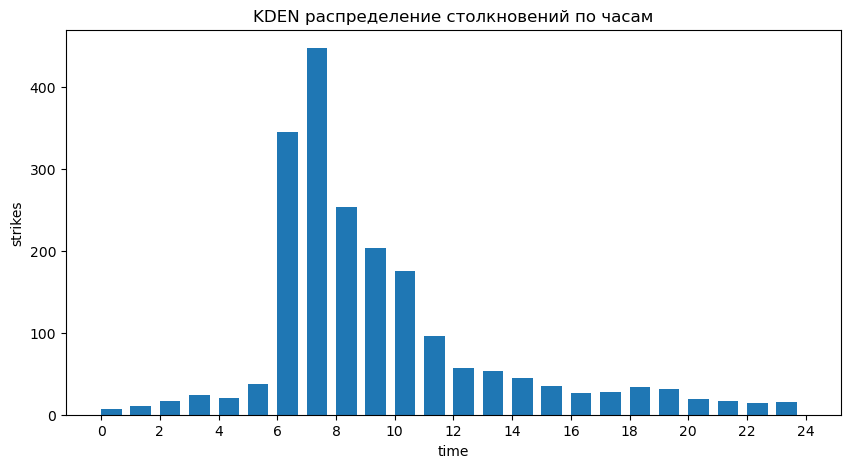

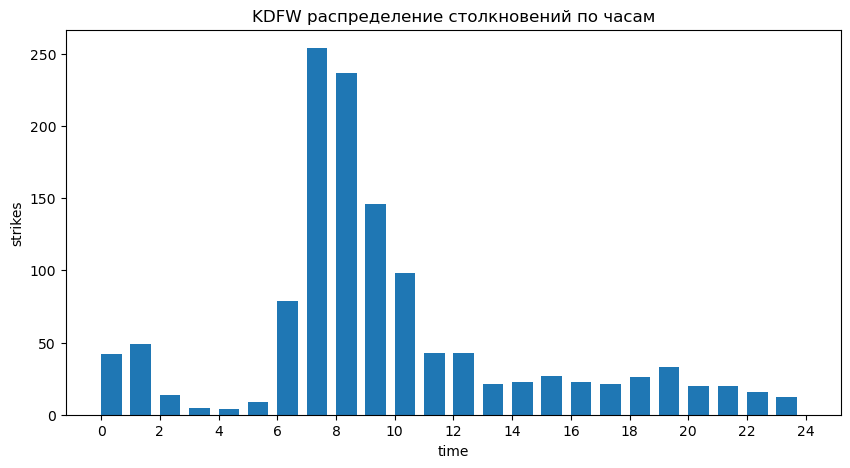

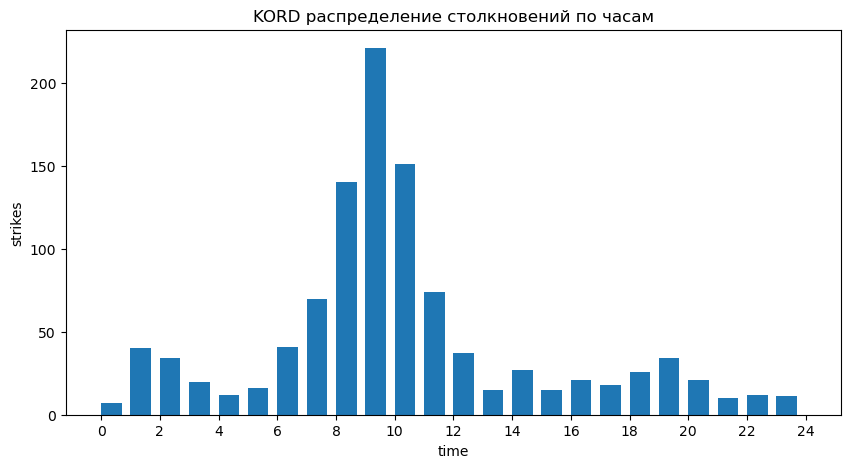

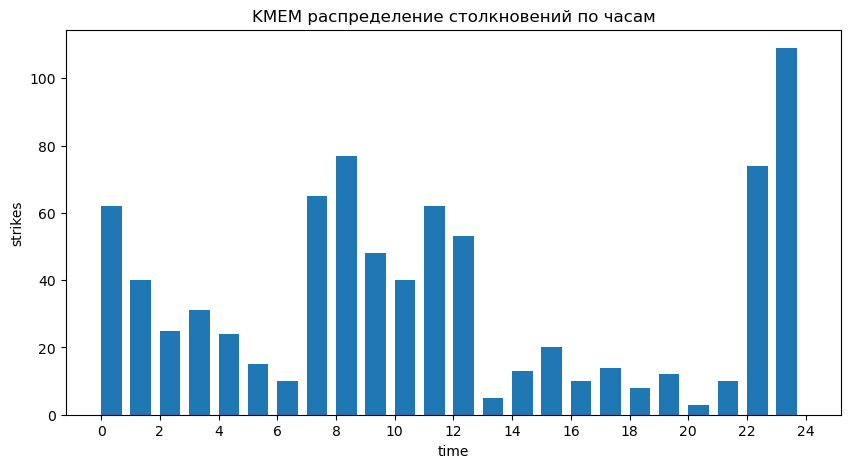

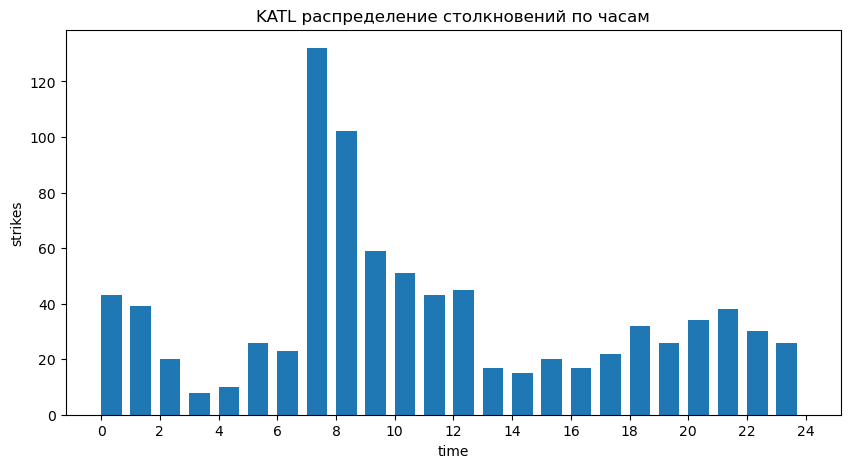

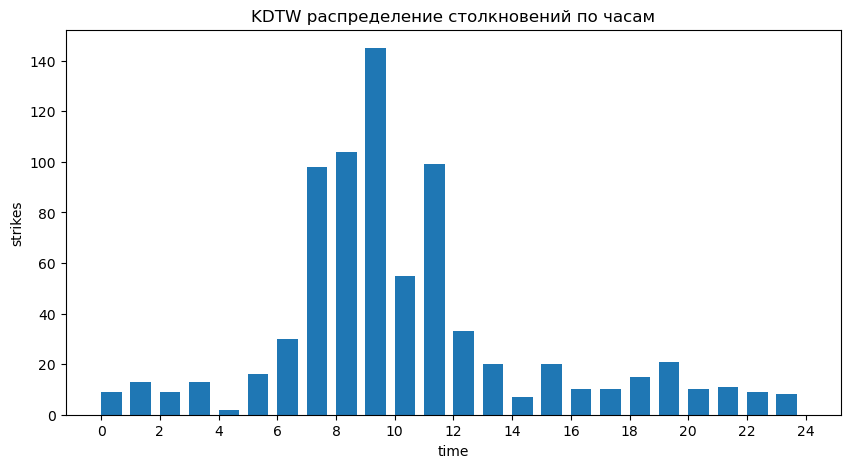

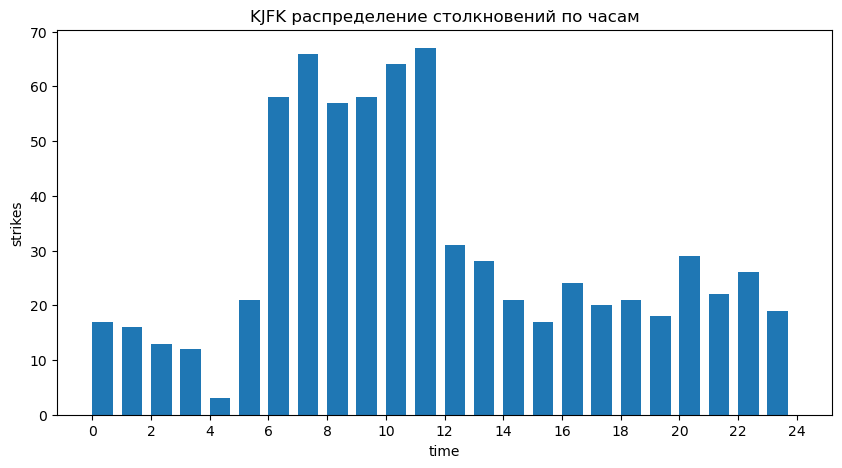

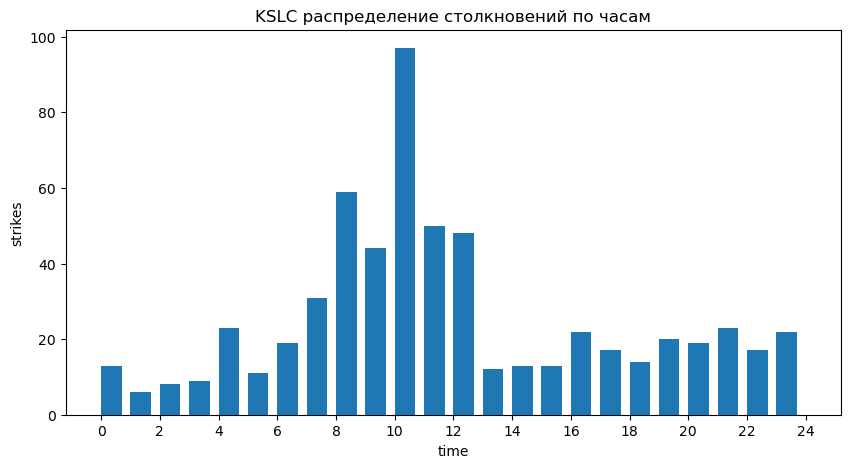

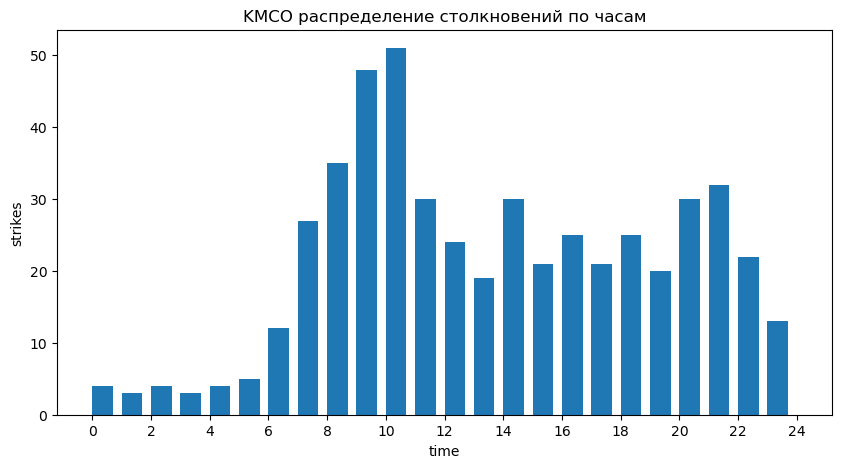

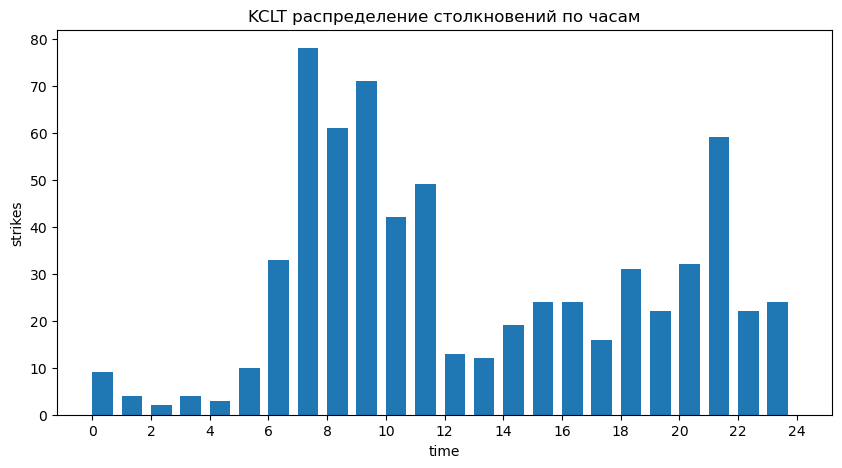

In [36]:
# построим диаграммы распределения столкновнеий в течение суток для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    plt.locator_params (axis='x', nbins=24) 
    plt.hist(strikes[(strikes['airport_id'] == airport) & 
                 (strikes['time'] < 24)]['time'], 
             bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
             width=0.7)
    plt.title(airport + ' распределение столкновений по часам')
    plt.xlabel('time')
    plt.ylabel('strikes')
    plt.show()

В целом столкновения сосредоточены в утренние часы, но распределения нельзя назвать одинаковыми, есть аэропрты с большими всплесками активности в вечерние и ночные часы, без ярко выраженного максимума. На эти распределения могут влиять распределения вылетов и прилетов, у нас, к сожалению, нет этой информации.

Так как у нас есть информация о количестве рейсов в месяц, перейдем от сравнения абсолютного количества столкновений к отнсительным.

## Определение аэропортов с наибольшими аномалиями

In [37]:
# сортируем по убыванию абсолютного количества столкновений в месяц
top_airports.sort_values(by='strikes', ascending=False).head()

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
54,KDEN,2022,7,2022-07-01,26218,178,678.9,4.1,22000.0,16093.0,21.7,10.6,10118.0
42,KDEN,2021,7,2021-07-01,27146,147,541.5,4.6,22000.0,16093.0,21.4,10.6,10121.0
5,KDEN,2018,6,2018-06-01,25214,130,515.6,4.6,22000.0,16000.0,16.1,6.4,10087.0
41,KDEN,2021,6,2021-06-01,25200,128,507.9,4.6,22000.0,16093.0,19.4,8.9,10092.0
53,KDEN,2022,6,2022-06-01,25296,115,454.6,4.1,22000.0,16093.0,18.9,4.4,10108.0


По абсолютному количеству столкновений в месяц лидирует Международный аэропорт Денвер, штат Колорадо (KDEN), особые проблемы в июне и июле

In [38]:
# сортируем по убыванию относительного количества столкновений на 100тыс рейсов
top_airports.sort_values(by='strikes_by_100000', ascending=False).head()

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
268,KMEM,2020,5,2020-05-01,601,54,8985.0,3.10,7620.0,16093.0,20.6,14.40,10138.0
267,KMEM,2020,4,2020-04-01,656,24,3658.5,3.35,7620.0,16093.0,15.3,10.55,10164.0
297,KMEM,2022,10,2022-10-01,1852,45,2429.8,3.10,22000.0,16093.0,16.1,5.00,10175.5
273,KMEM,2020,10,2020-10-01,1410,34,2411.3,2.60,22000.0,16093.0,14.4,8.90,10193.0
269,KMEM,2020,6,2020-06-01,780,18,2307.7,2.35,22000.0,16093.0,23.6,17.80,10165.0


По количеству столкновений в месяц на 100000 рейсов лидирует Международный аэропорт Мемфиса, штат Теннесси (KMEM), виден большой выброс в мае 2020 года

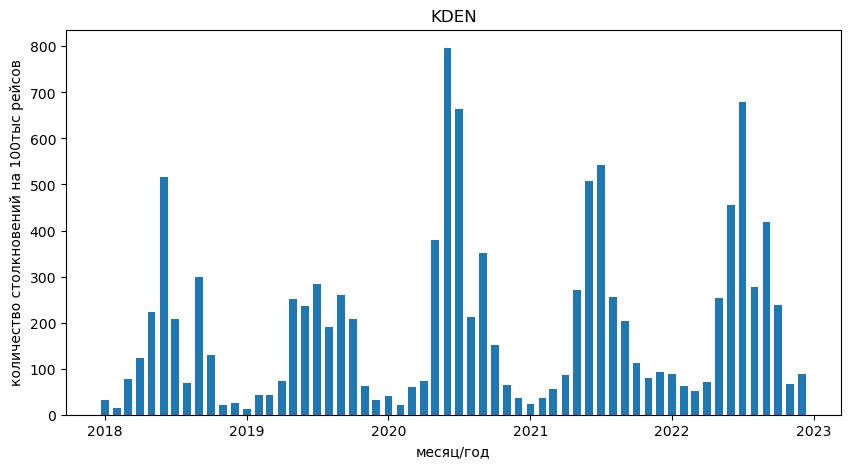

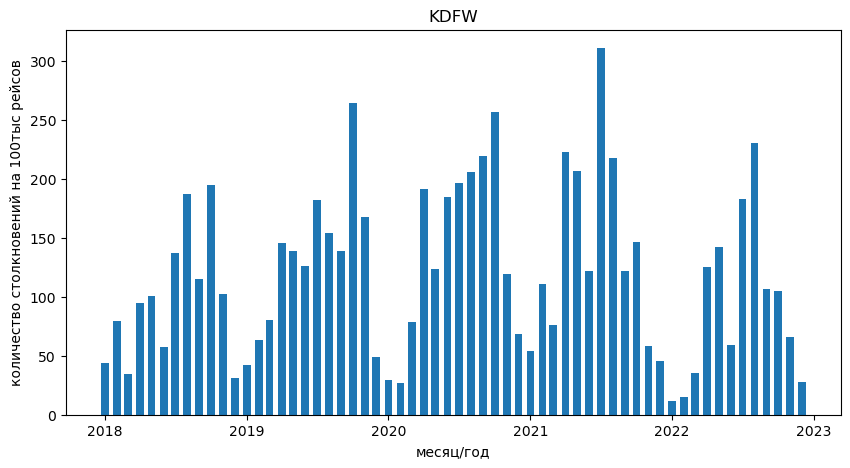

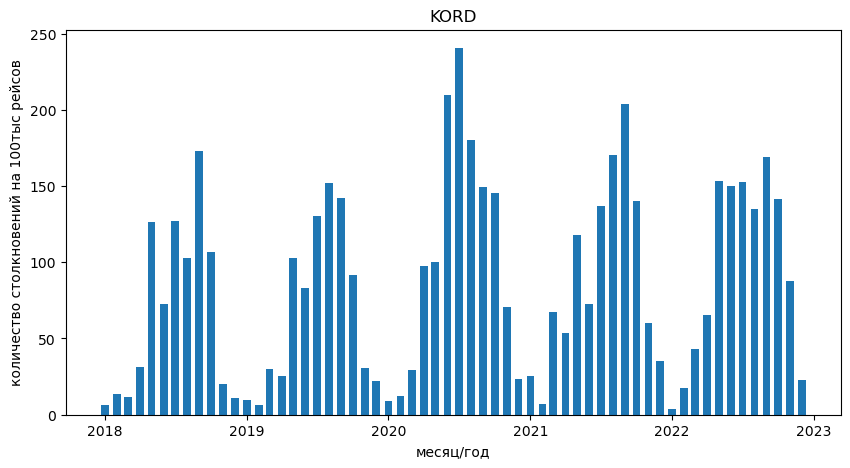

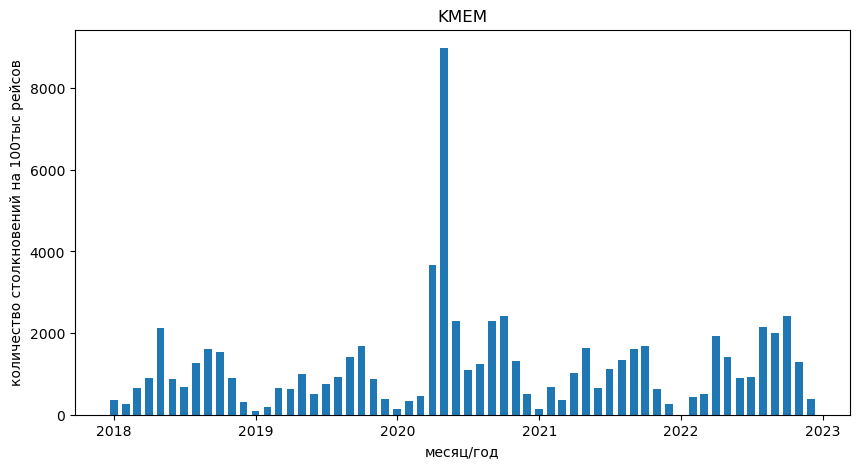

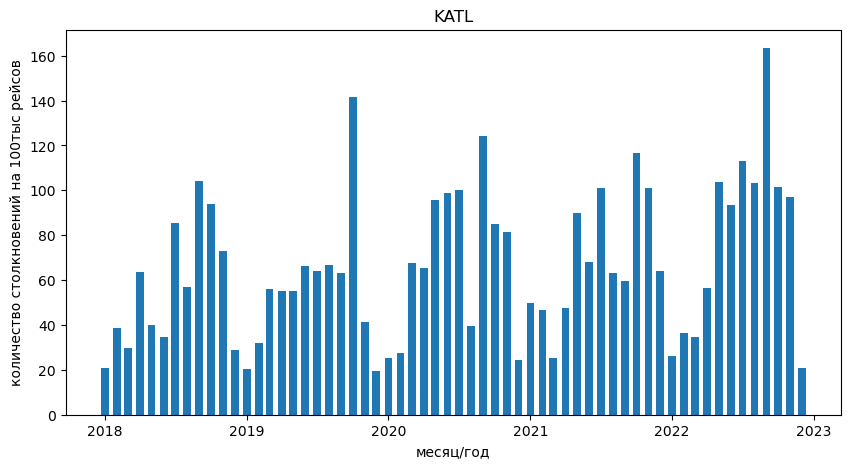

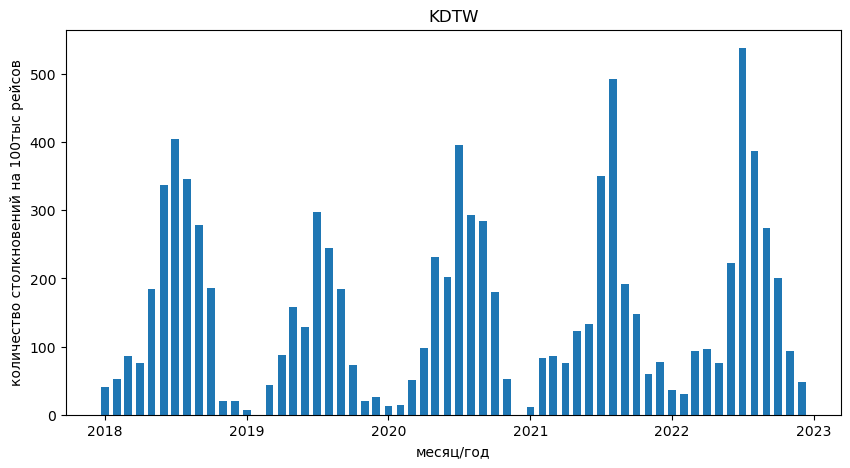

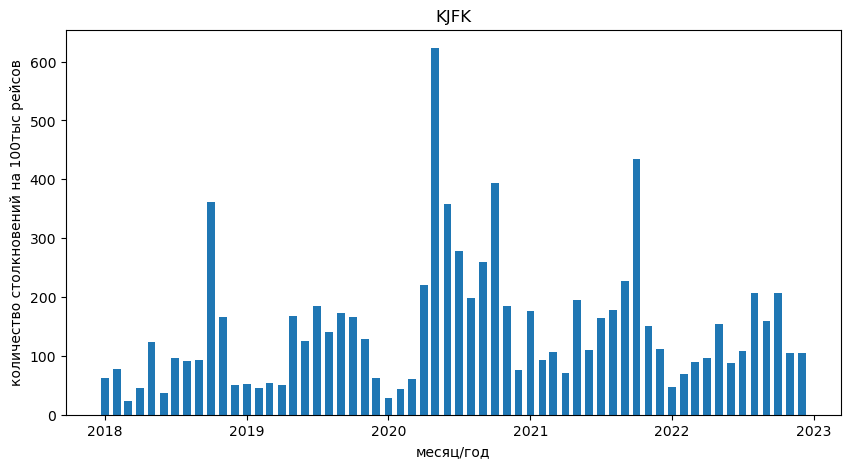

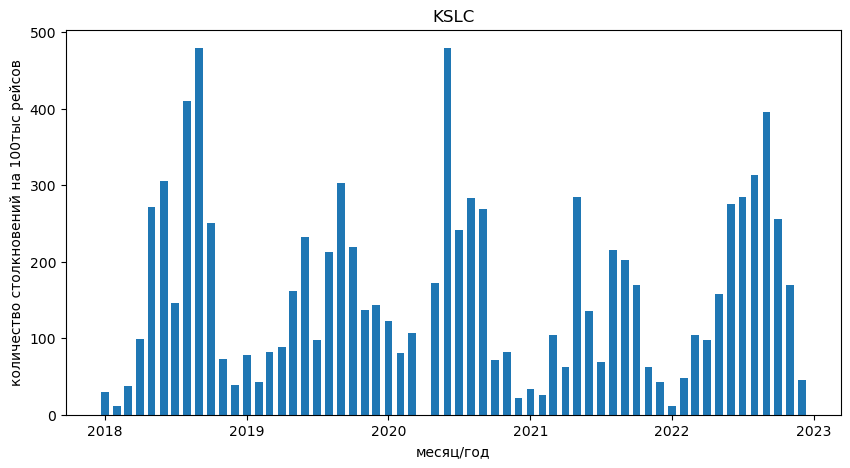

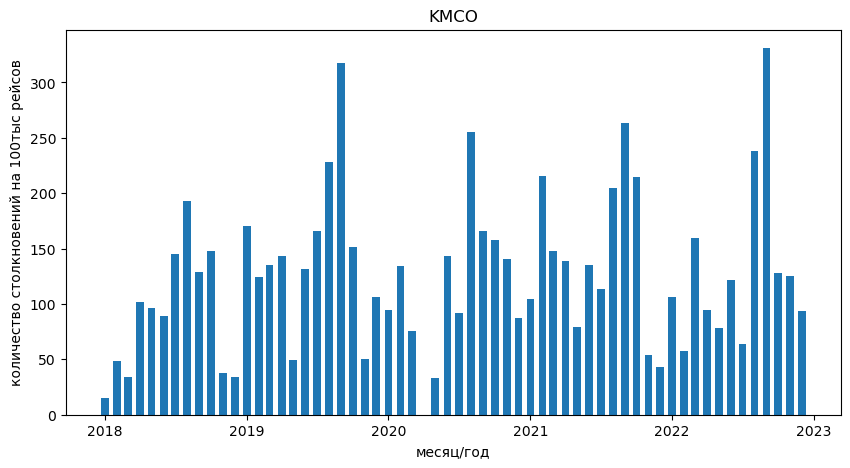

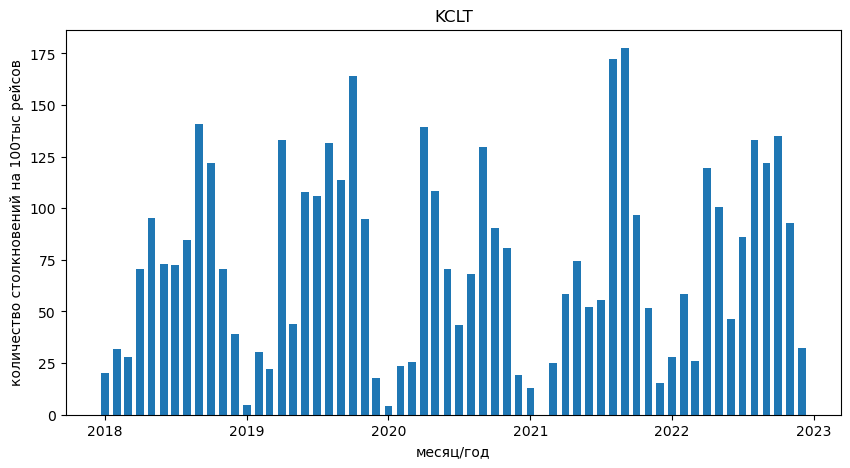

In [39]:
# построим диаграмму относительного количества столкновений для каждого аэропорта по годам и месяцам
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    plt.bar(top_airports[top_airports['airport_id'] == airport]['date'], 
            top_airports[top_airports['airport_id'] == airport]['strikes_by_100000'],
           width=20)
    plt.title(airport)
    plt.xlabel('месяц/год')
    plt.ylabel('количество столкновений на 100тыс рейсов')
    plt.show()

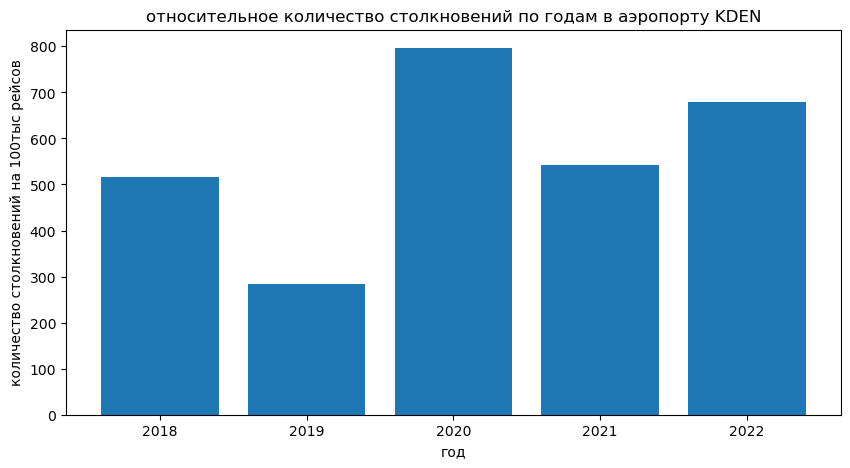

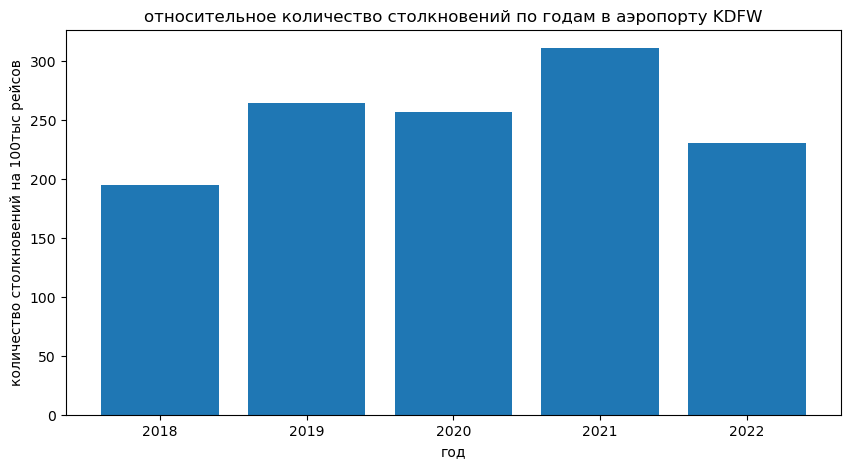

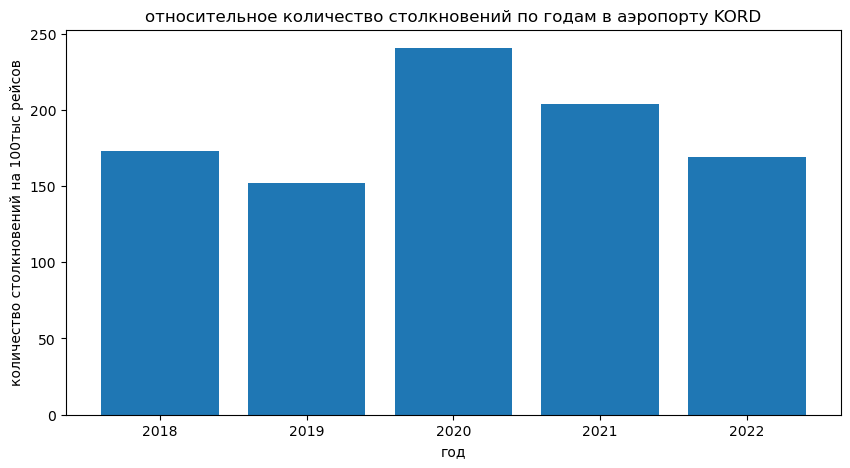

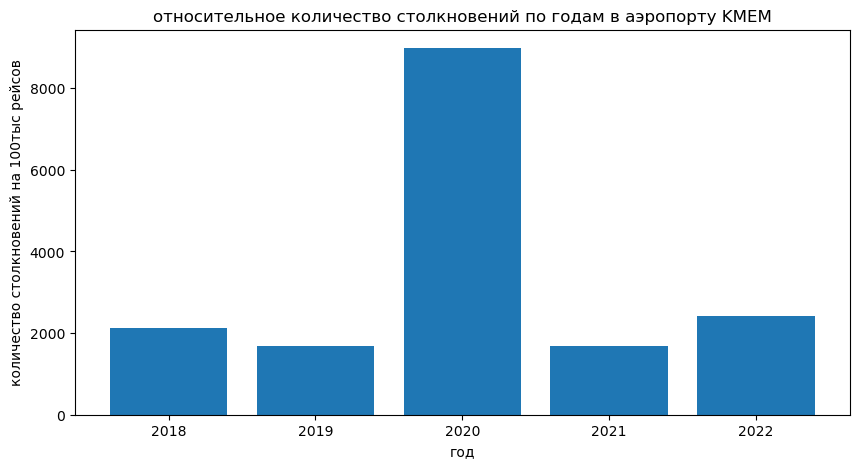

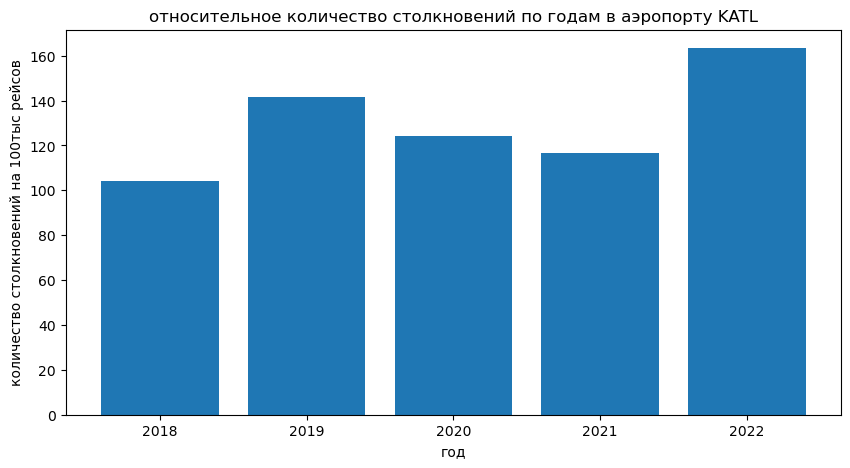

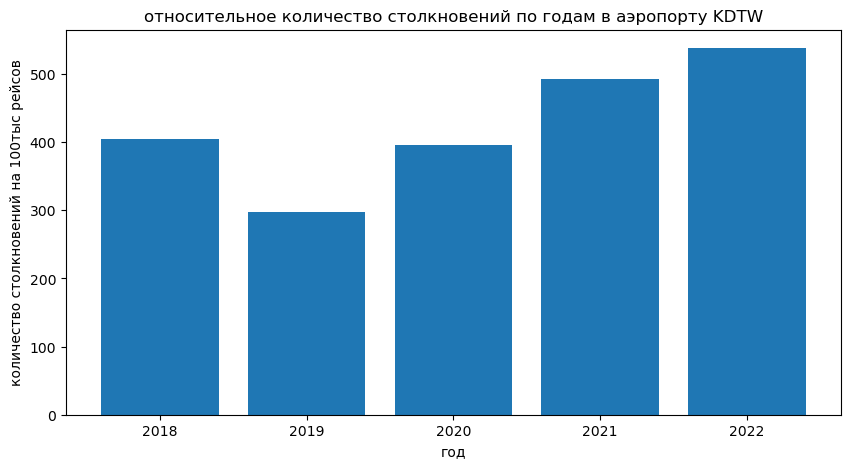

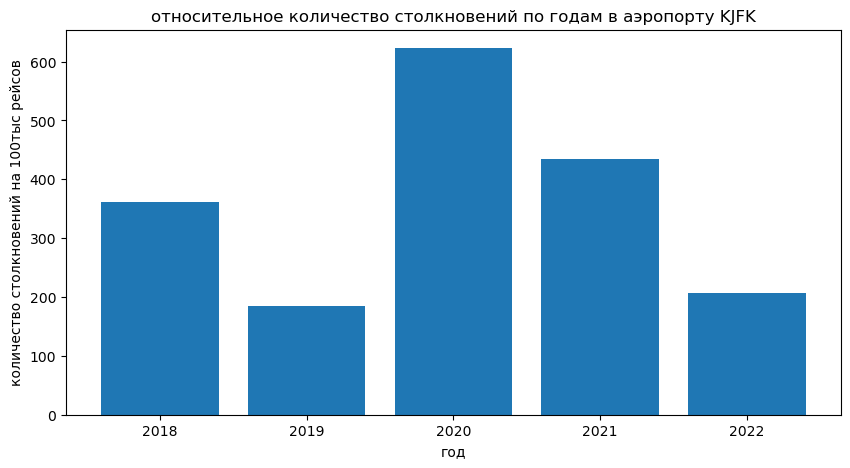

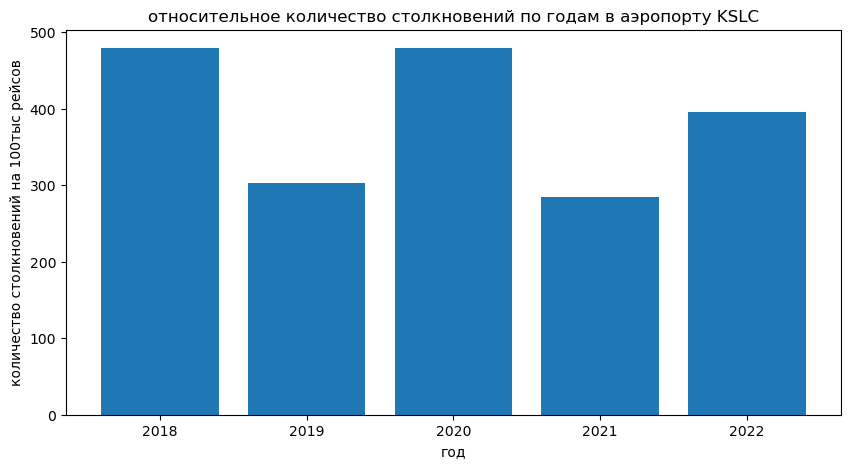

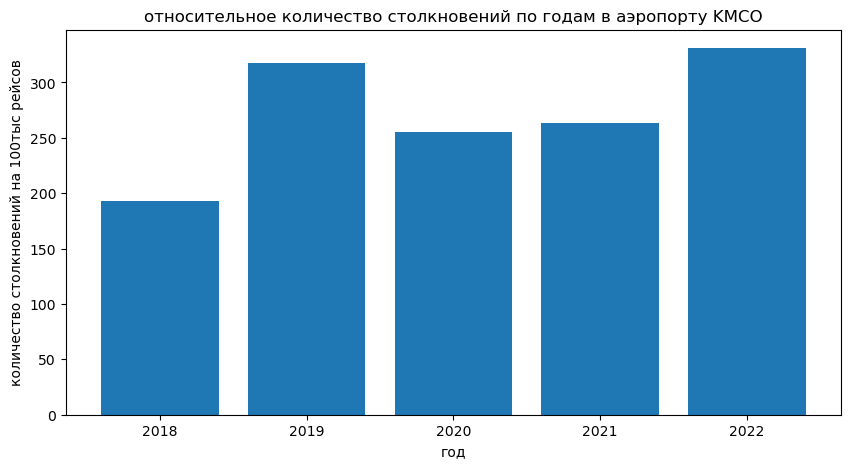

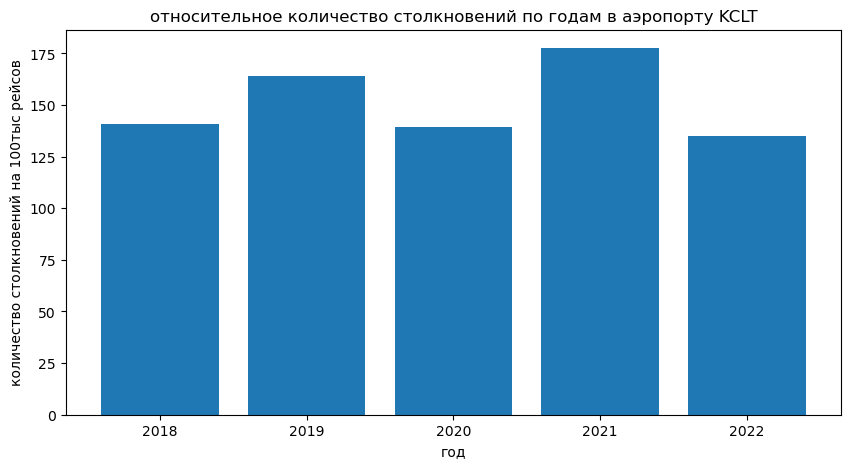

In [40]:
# построим диаграмму относительного количества столкновений для каждого аэропорта по годам
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    plt.bar(top_airports[top_airports['airport_id'] == airport]['year'], 
            top_airports[top_airports['airport_id'] == airport]['strikes_by_100000'])
    plt.title( 'относительное количество столкновений по годам в аэропорту ' + airport)
    plt.xlabel('год')
    plt.ylabel('количество столкновений на 100тыс рейсов')
    plt.show()

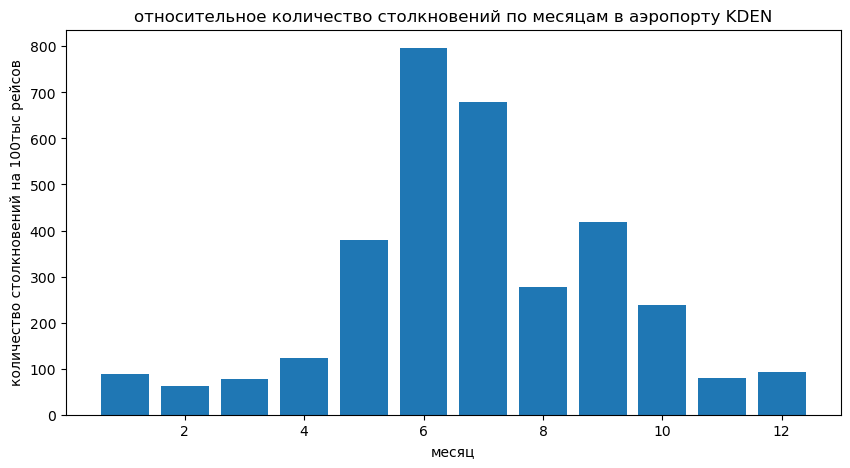

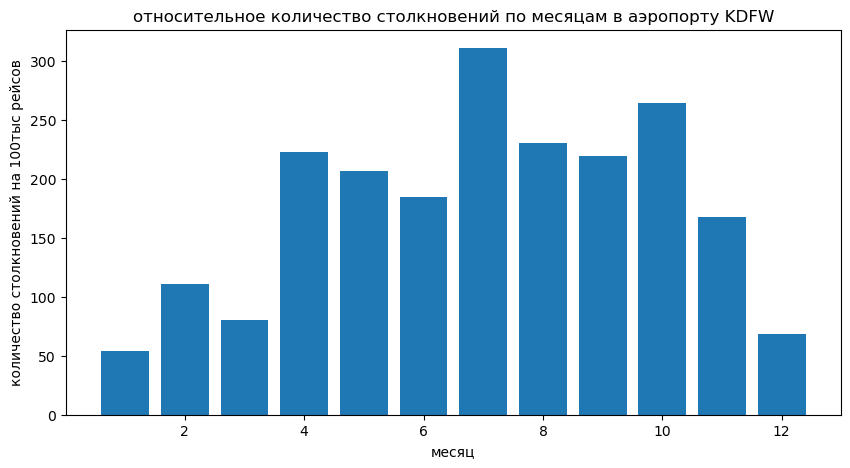

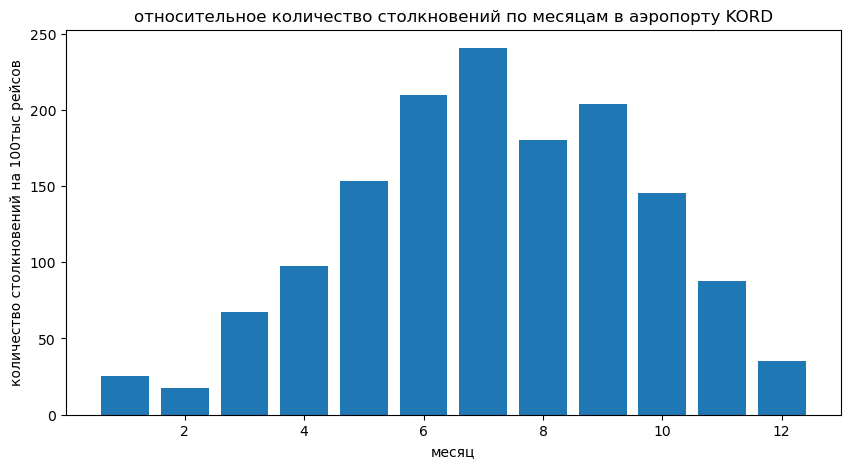

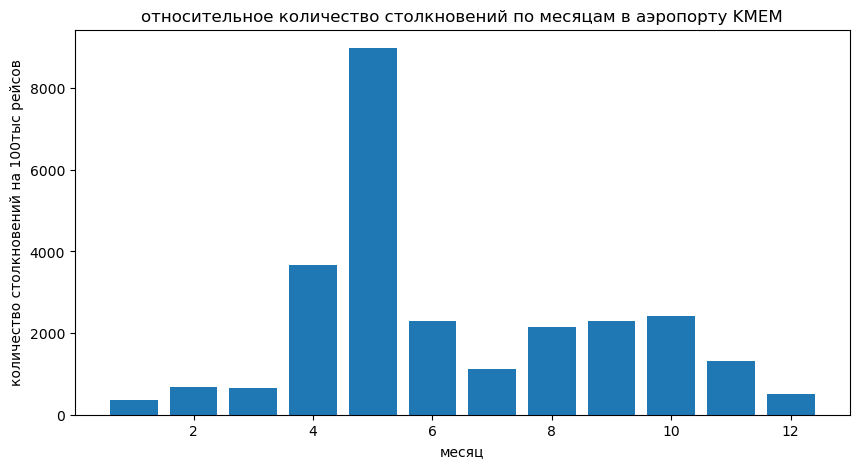

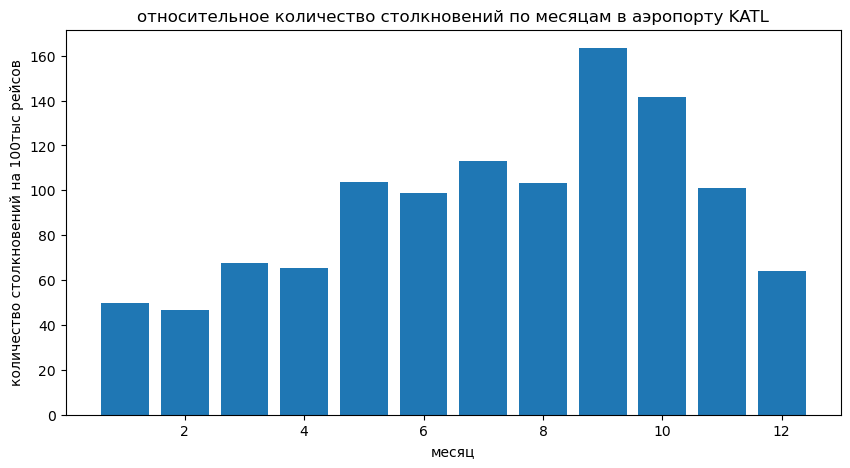

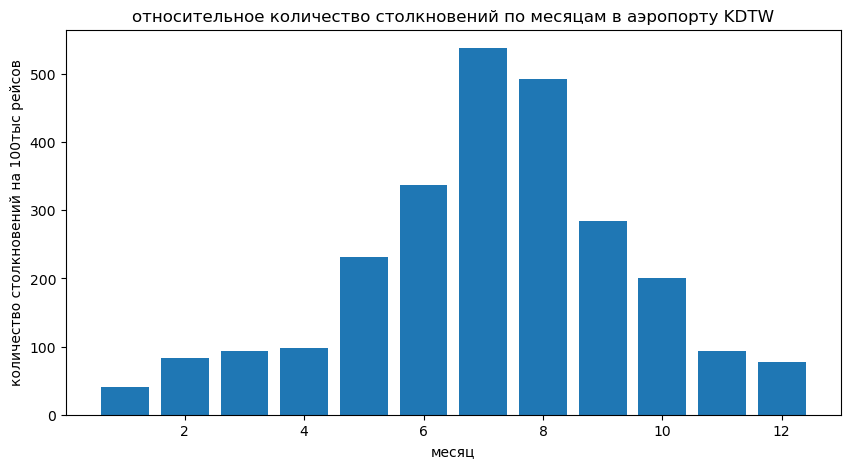

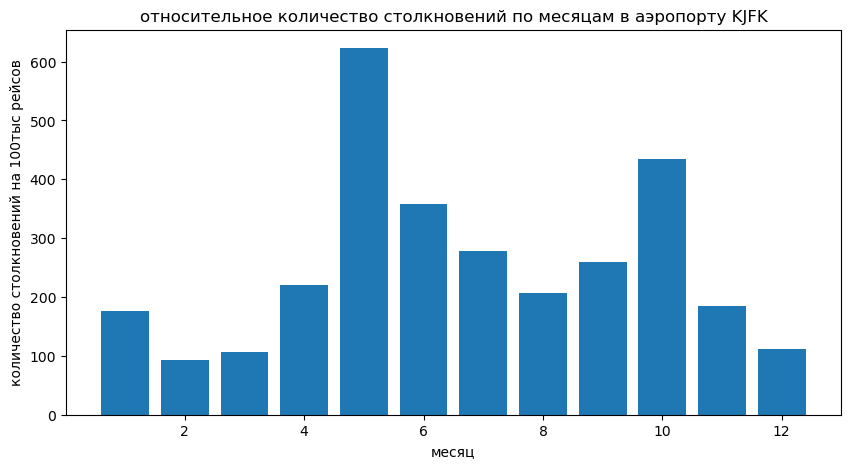

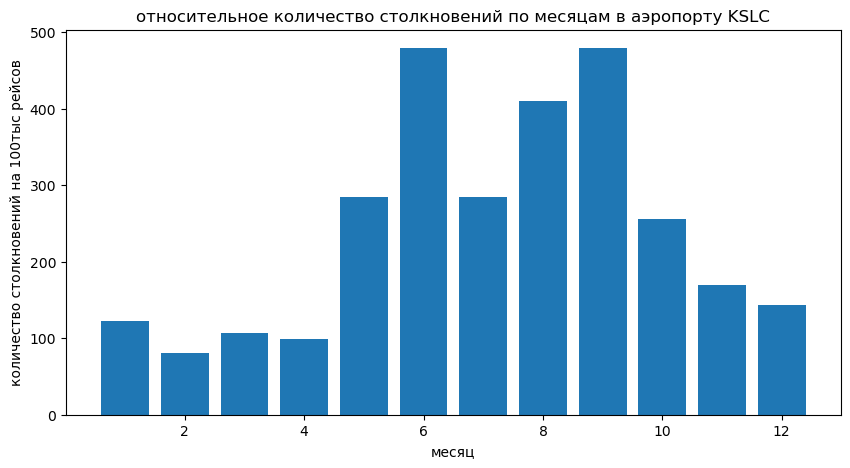

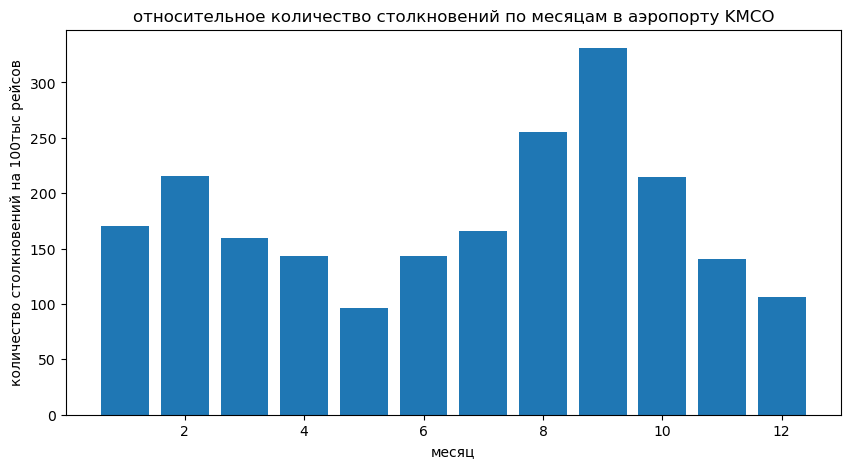

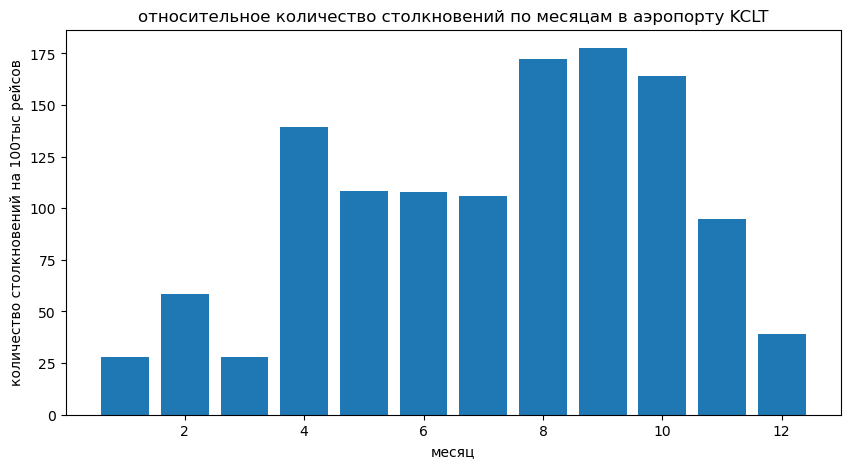

In [41]:
# построим диаграмму относительного количества столкновений для каждого аэропорта по месяцам
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    plt.bar(top_airports[top_airports['airport_id'] == airport]['month'], 
            top_airports[top_airports['airport_id'] == airport]['strikes_by_100000'])
    plt.title( 'относительное количество столкновений по месяцам в аэропорту ' + airport)
    plt.xlabel('месяц')
    plt.ylabel('количество столкновений на 100тыс рейсов')
    plt.show()

Как и в случае с временем суток мы не видим одинаковых распределений ни по годам ни по месяцам. Как правило, в теплое время года происходит больше столкновений, в разных аэропортах максимумы встречаются с мая по сентябрь, где-то начало полетов молодняка добавляет больше риска столкновений, где-то осенняя миграция. Разброс значений в аэропортах очень разный.

Аэропорт KMEM имеет самый выдающийся выброс в мае 2020 года. Меньшие, но похожие выбросы в тот же год в летний период имеют аэропорты KDEN, KORD, KJFK. В других аэропортах тоже присутствуют аномальные выбросы в другое время.

## Изучение зависимости относительного количества столкновений от погодных факторов

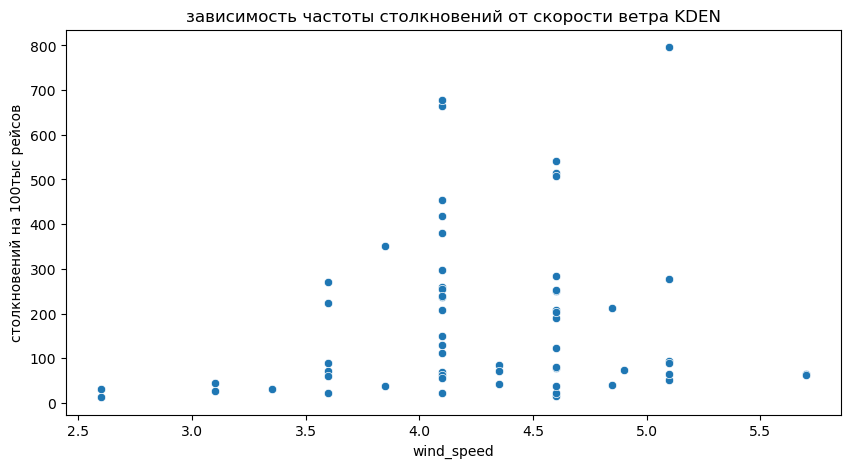

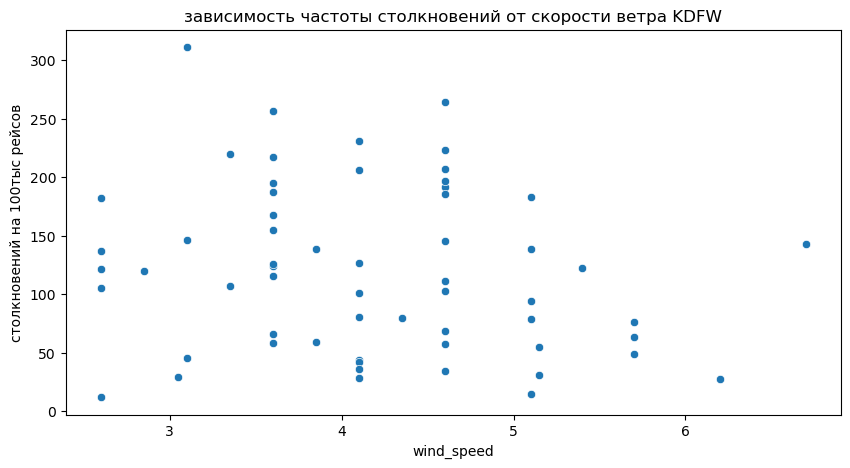

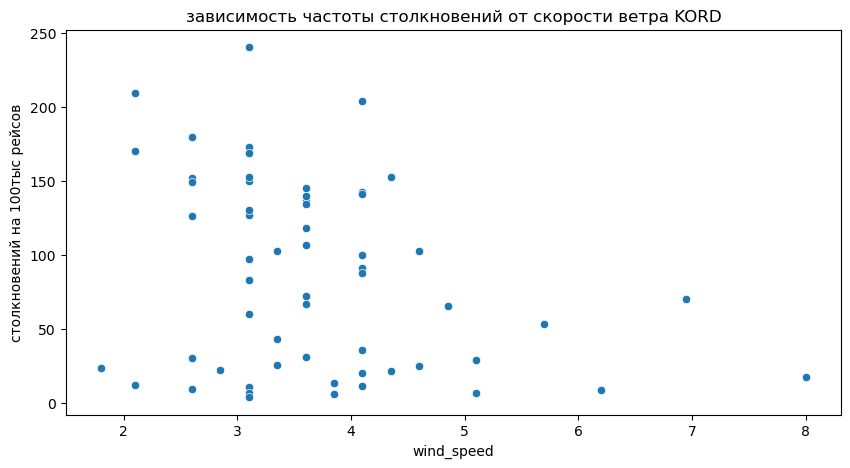

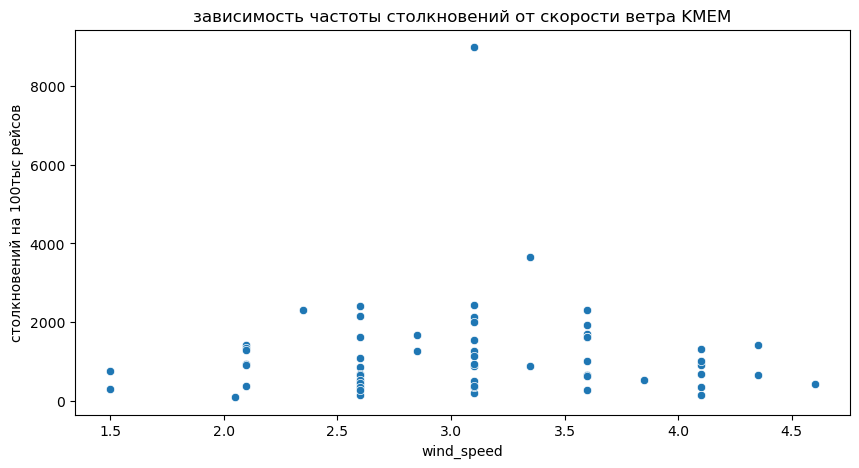

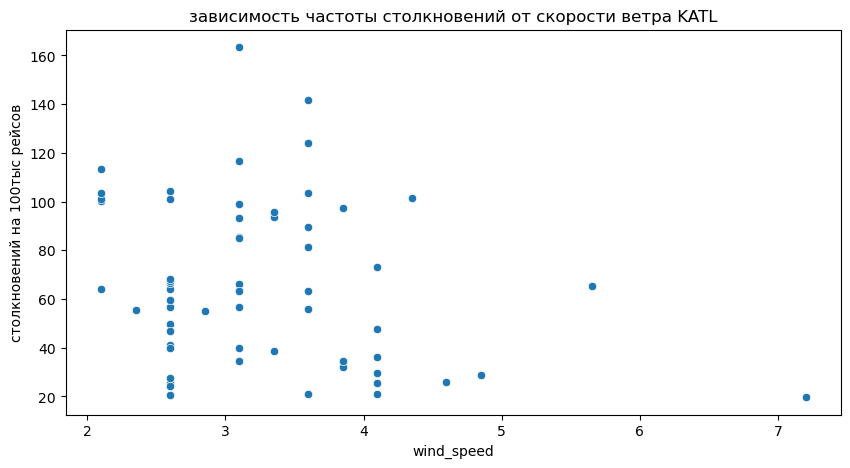

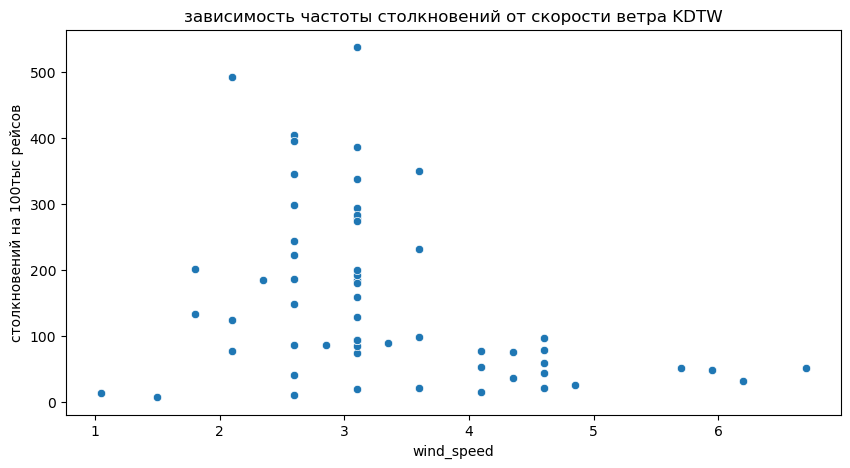

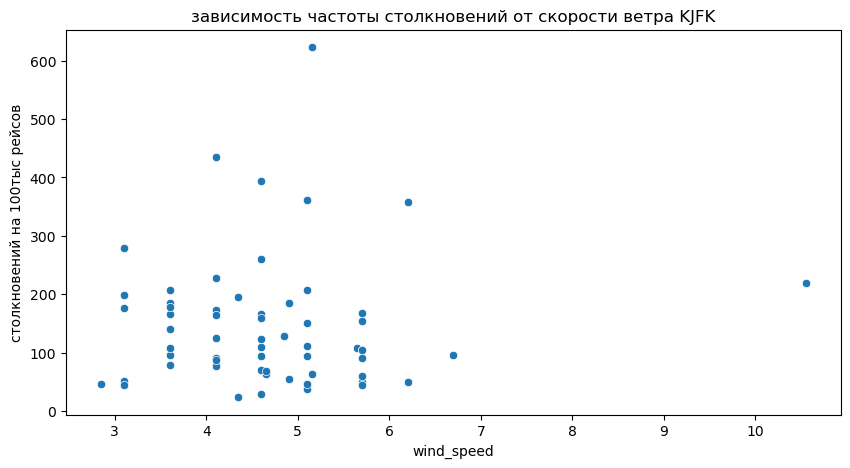

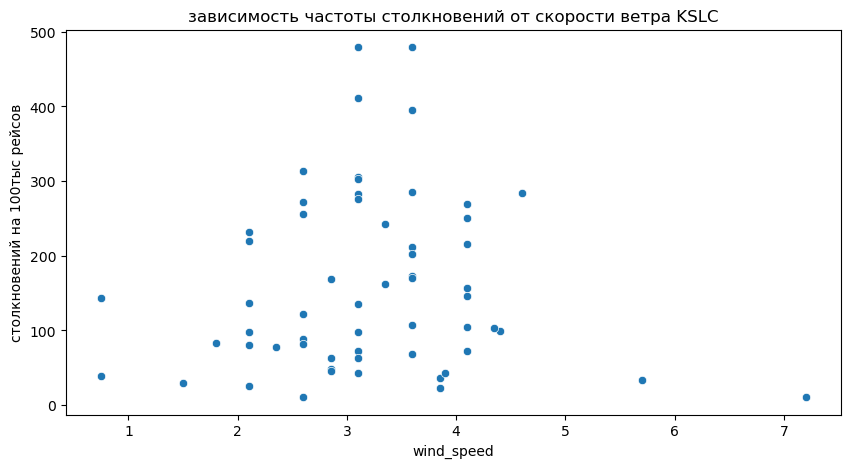

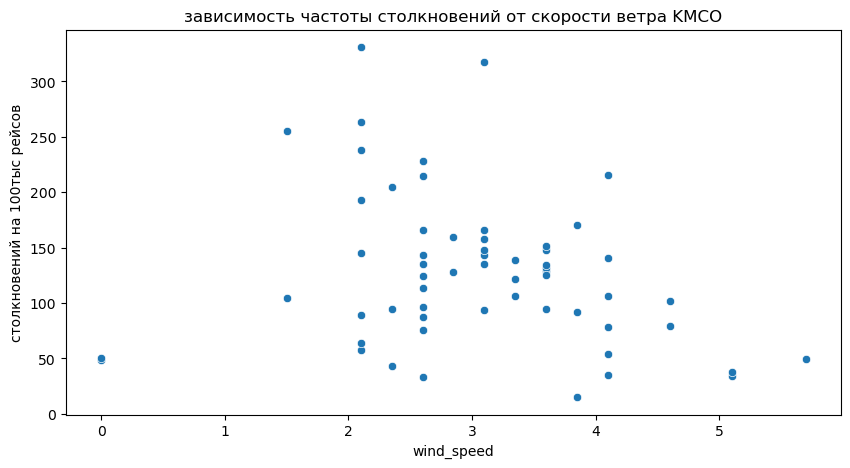

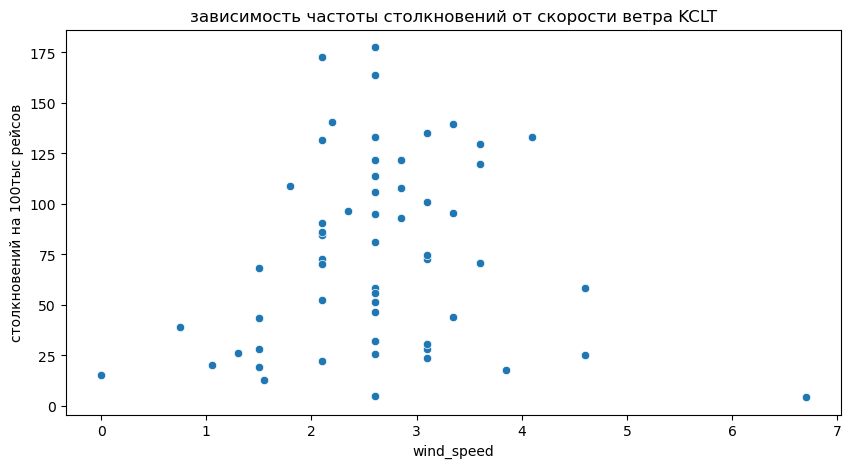

In [42]:
## построим диаграмму рассеяния: зависимость частоты столкновений от скорости ветра для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="wind_speed", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от скорости ветра ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

В каждом аэропорту мы не наблюдаем линейной зависимости от скорости ветра

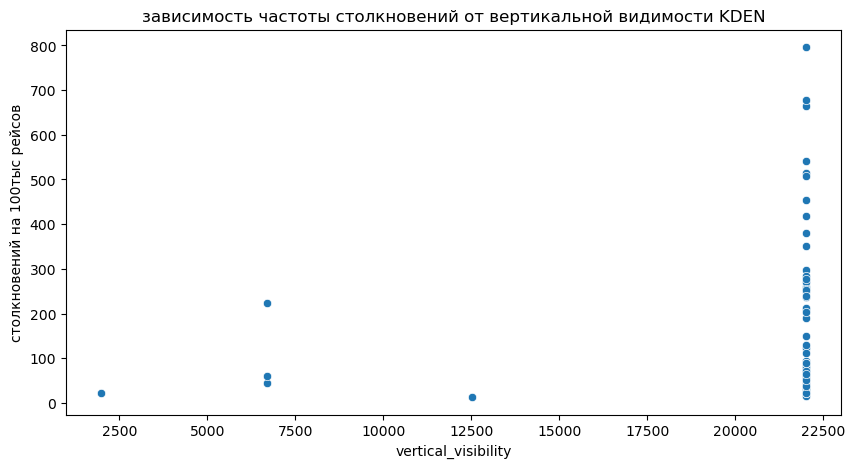

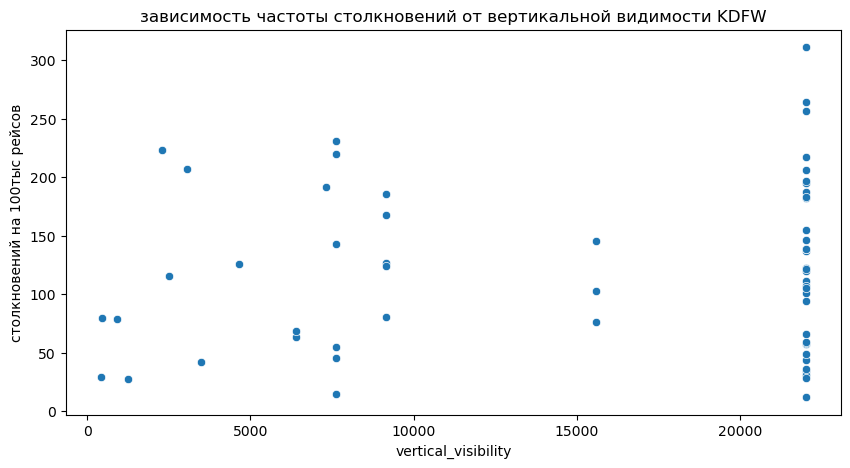

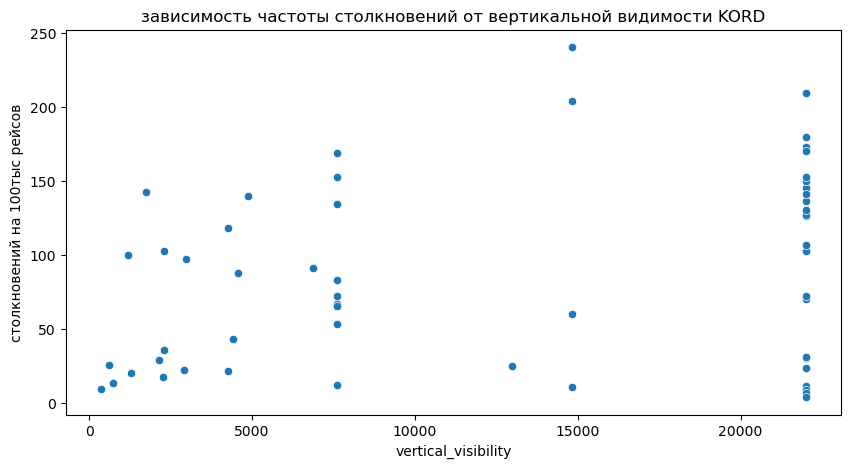

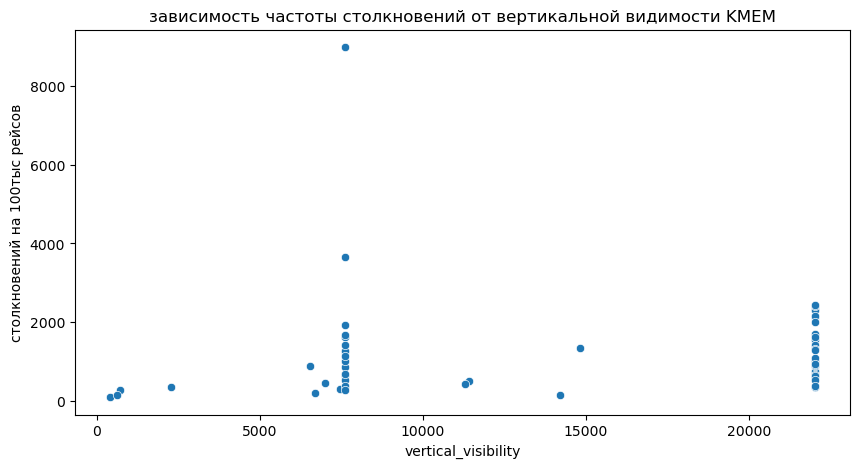

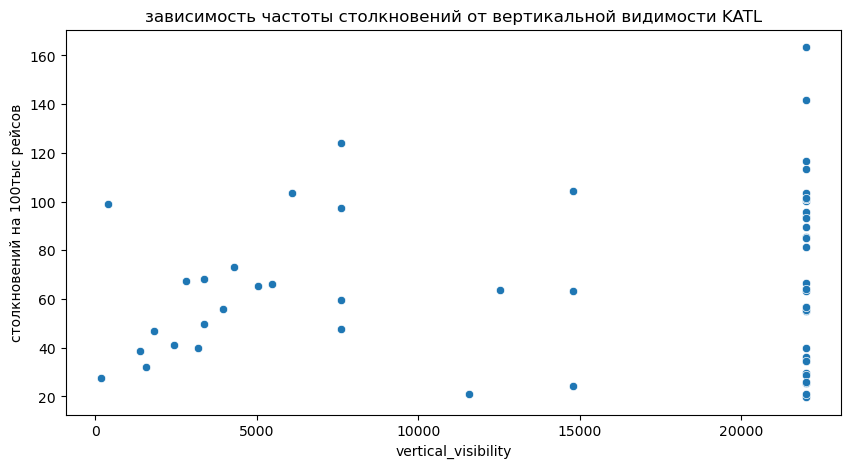

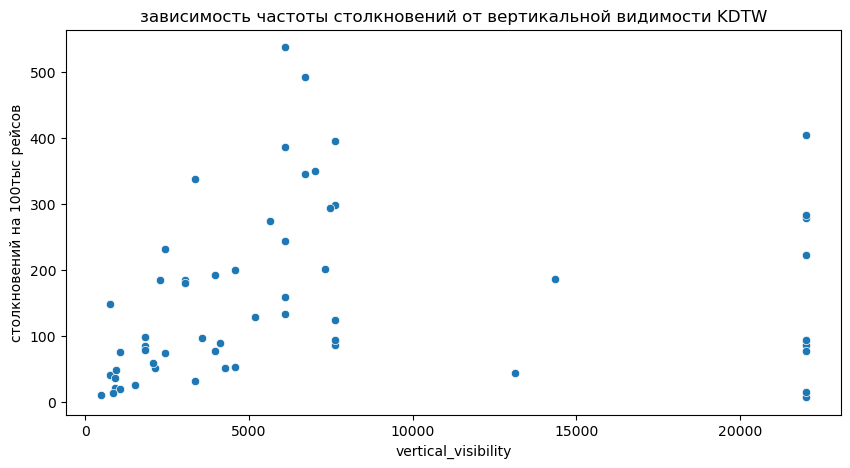

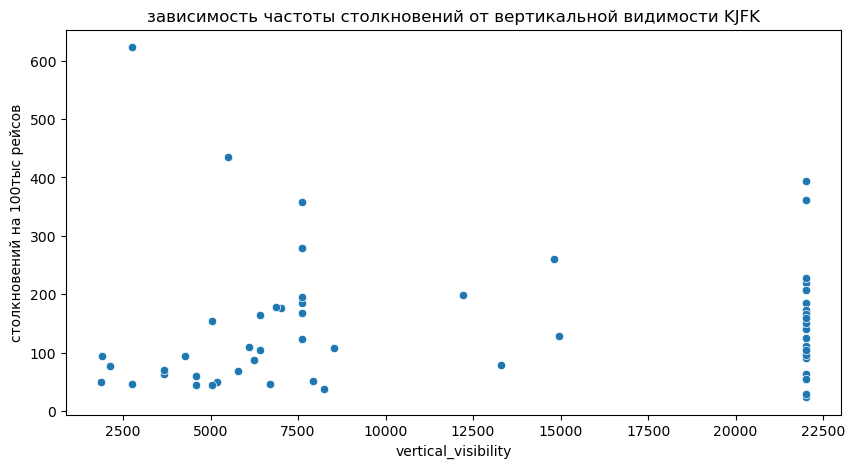

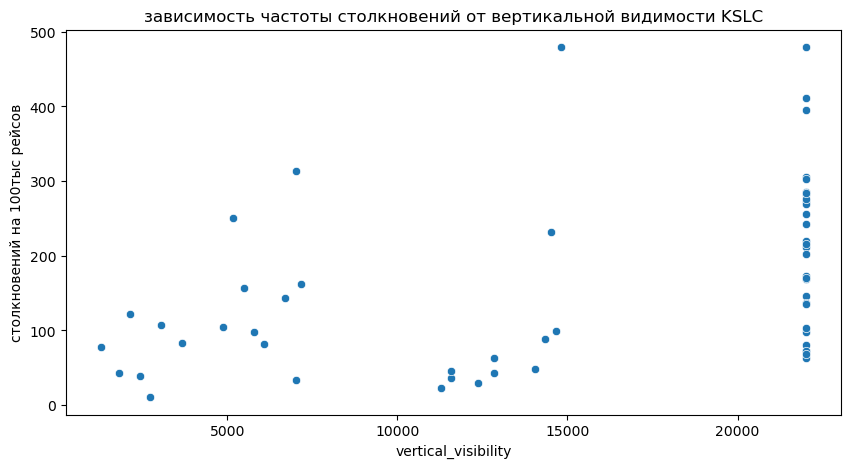

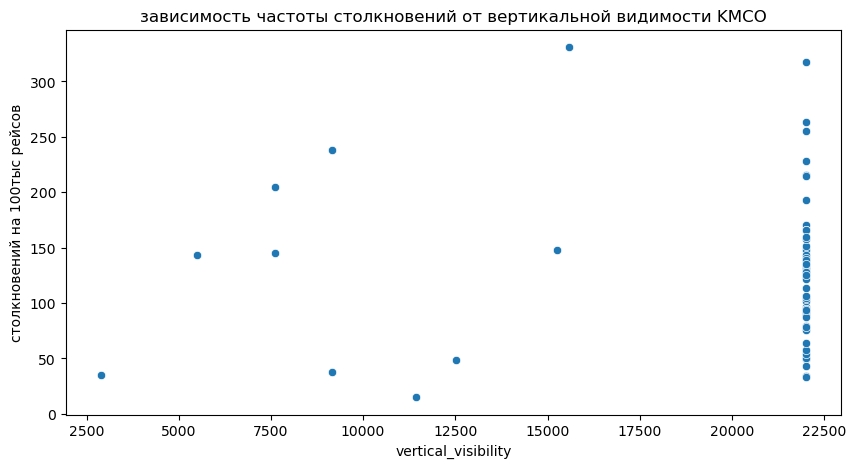

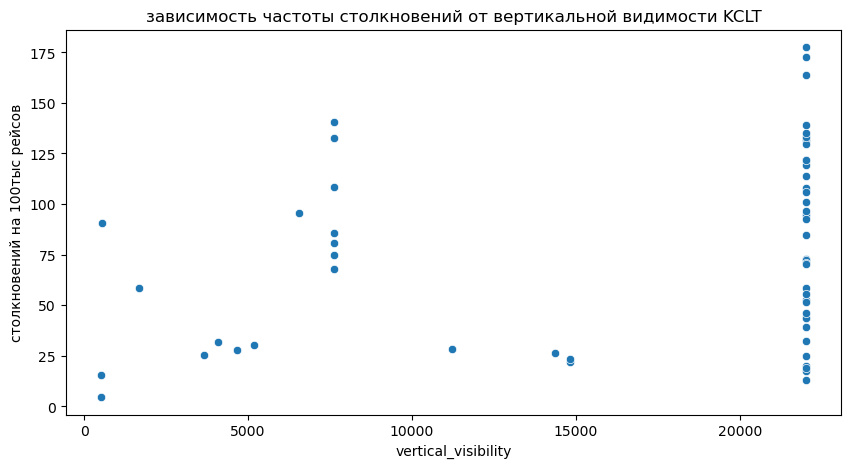

In [43]:
## построим диаграмму рассеяния: зависимость частоты столкновений от вертикальной видимости для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="vertical_visibility", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от вертикальной видимости ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

Вероятно, вертикальная видимость выше 5-10 тысяч метров, меньше влияет на вероятность столкновений, чем разница в видимости до 5 тысяч метров (именно на этой высоте располагаются дождевые облака). Видимость в пределах первой тысячи метров должна сильнее всего влиять на поведение птиц и самолетов при взлете и посадке). До 5тыс метров наблюдается небольшая прямая линейная зависимость.

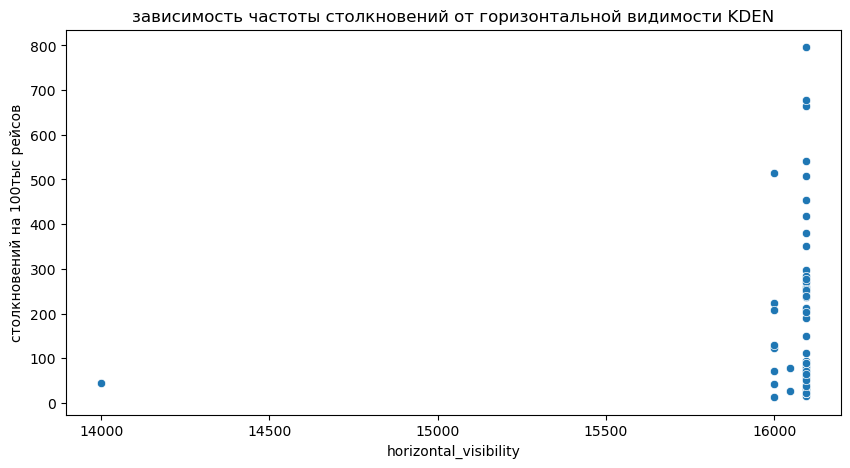

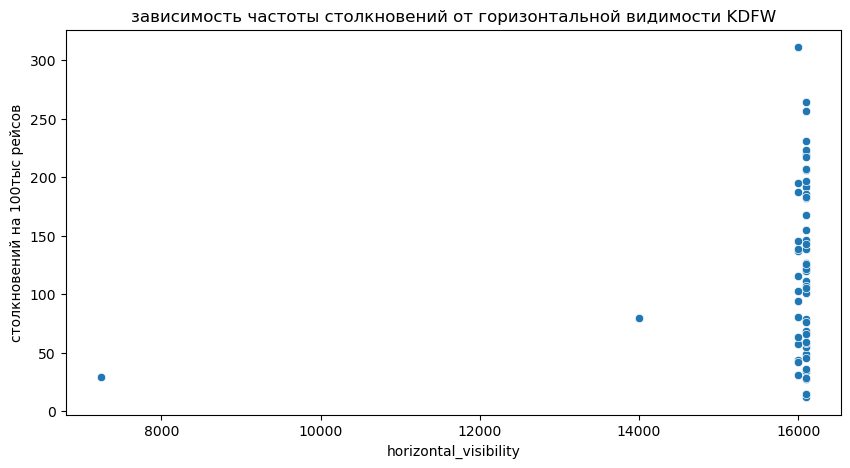

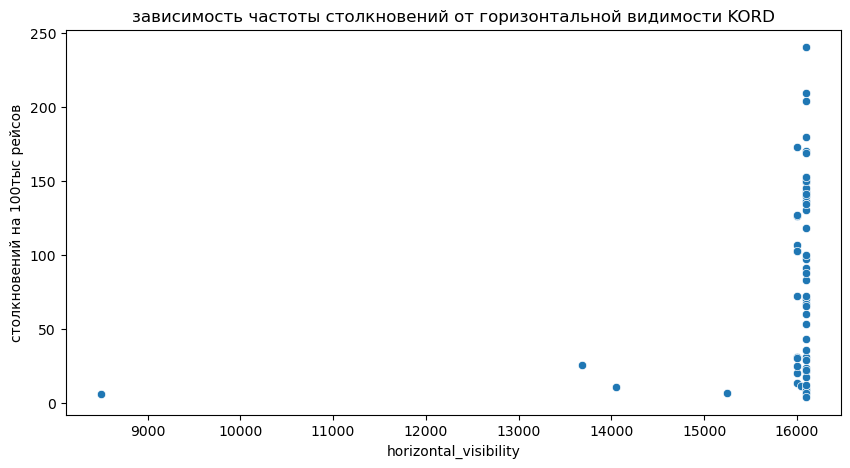

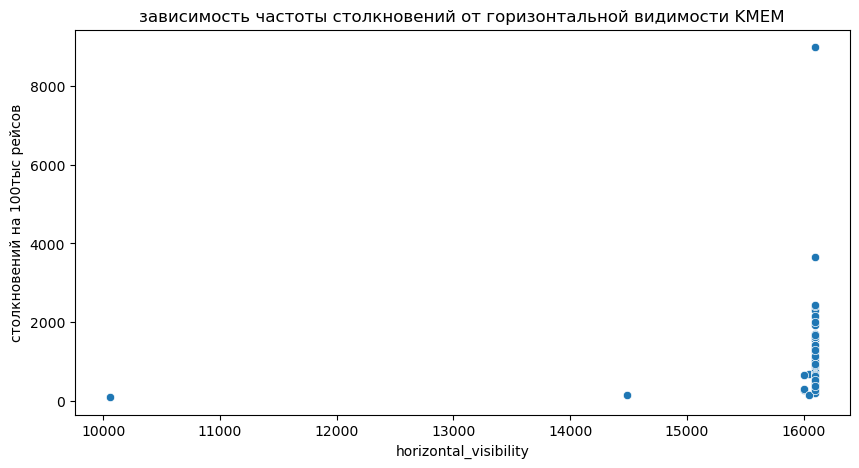

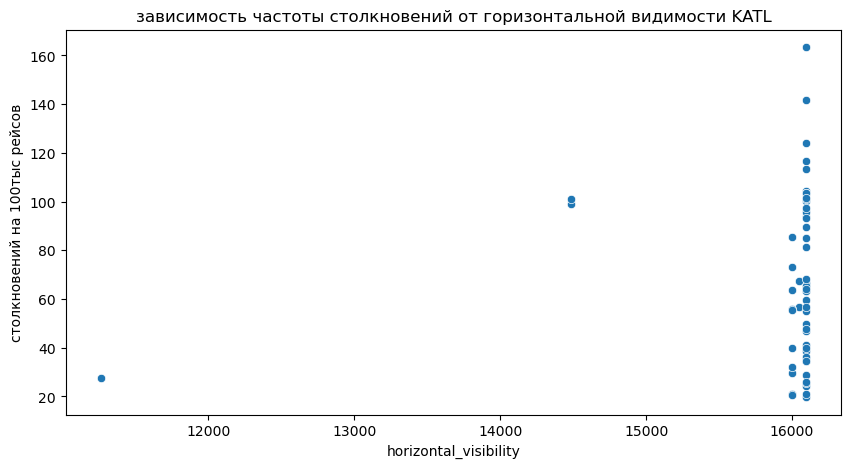

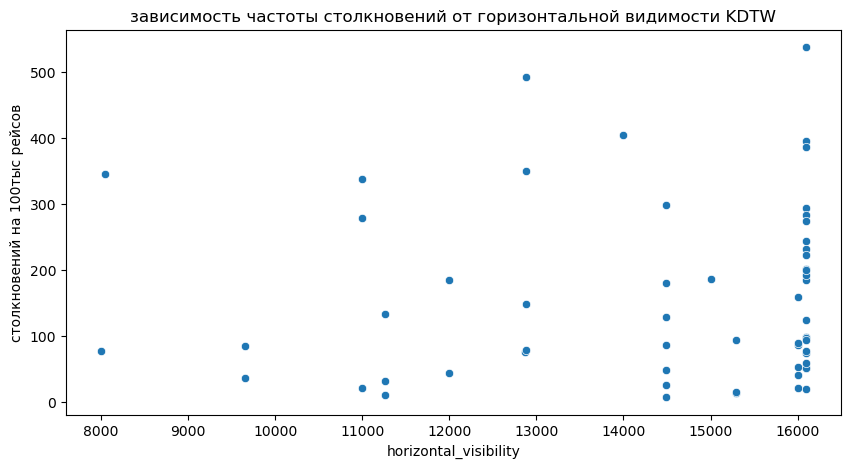

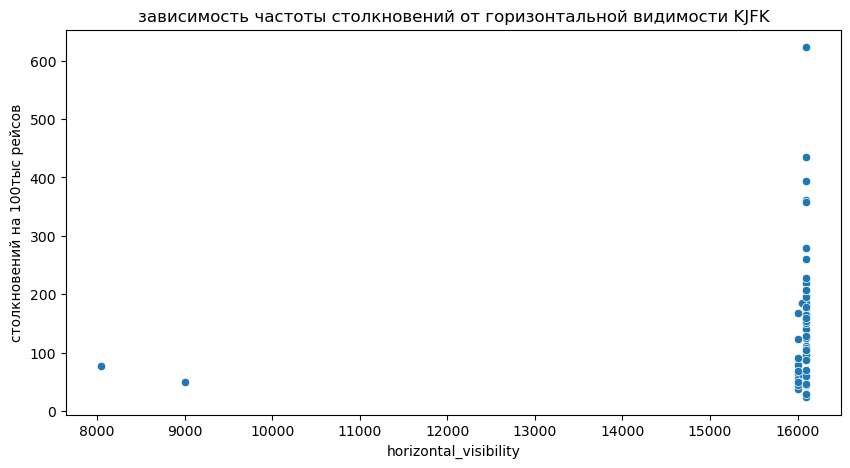

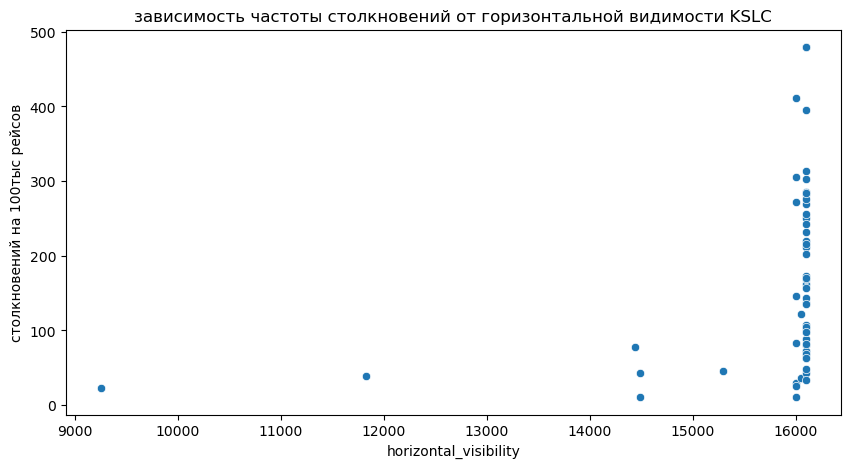

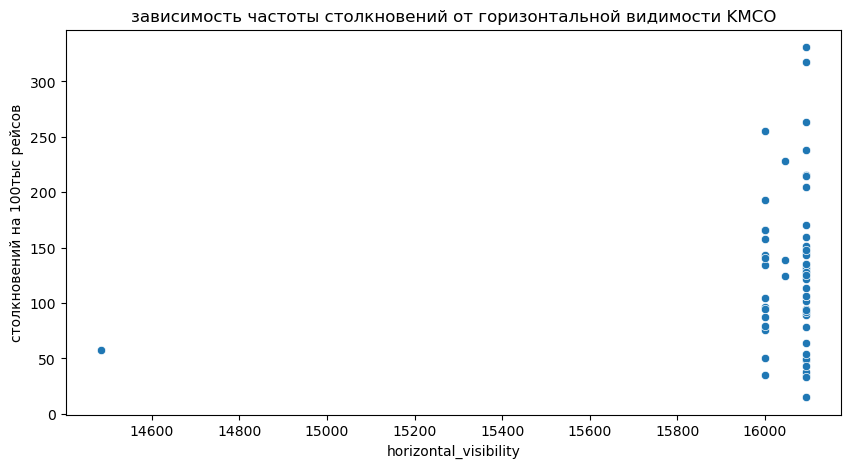

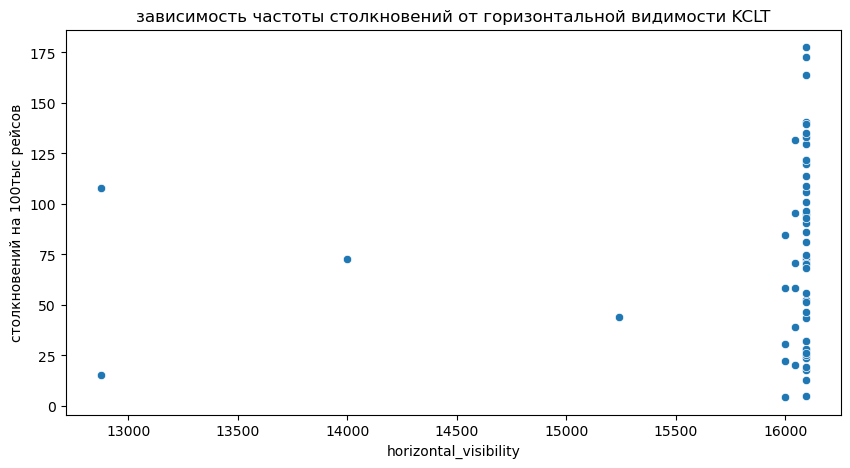

In [44]:
## построим диаграмму рассеяния: зависимость частоты столкновений от горизонтальной видимости для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="horizontal_visibility", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от горизонтальной видимости ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

Большинство столкновений происходит при хорошей горизонтальной видимости, вероятно, при плохой видимости и птицы и самолеты предпочитают не летать. Единственный аэропорт KDTW имеет достаточный разброс в наблюдениях, но там зависимости не наблюдается.

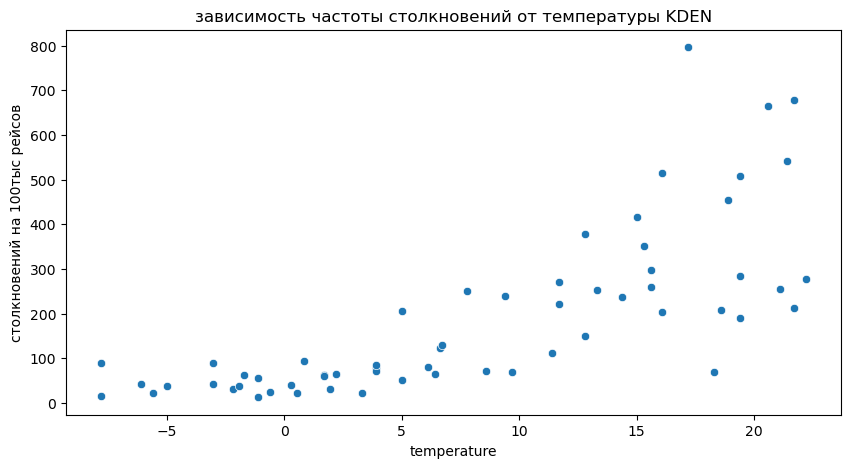

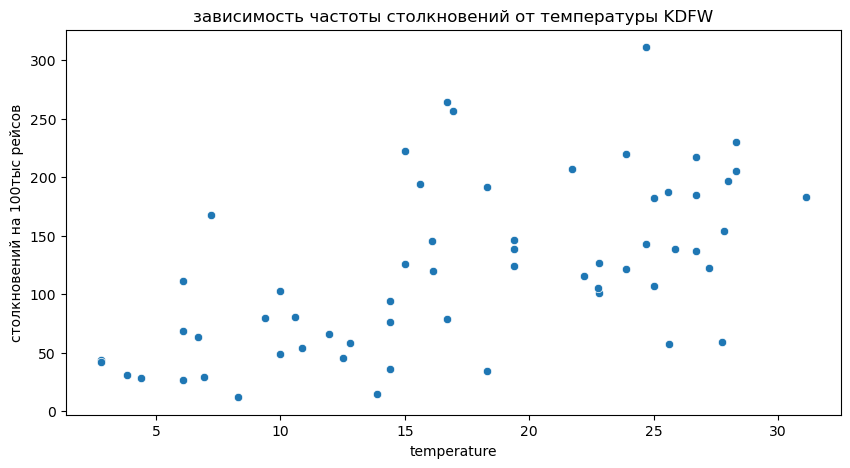

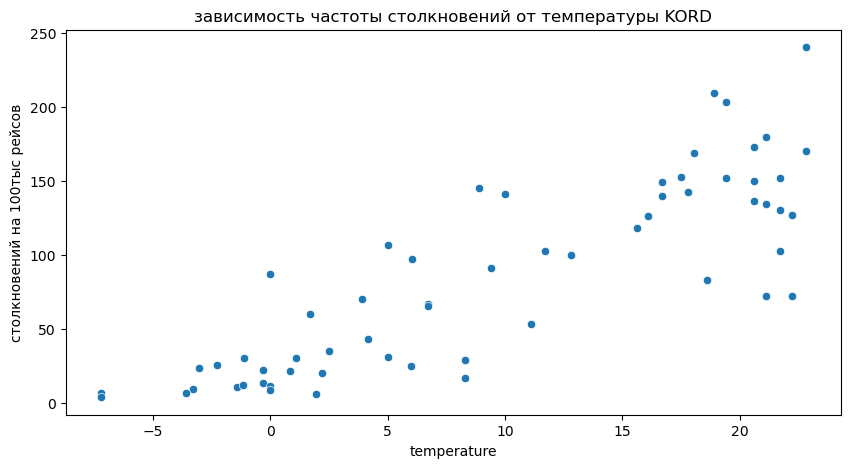

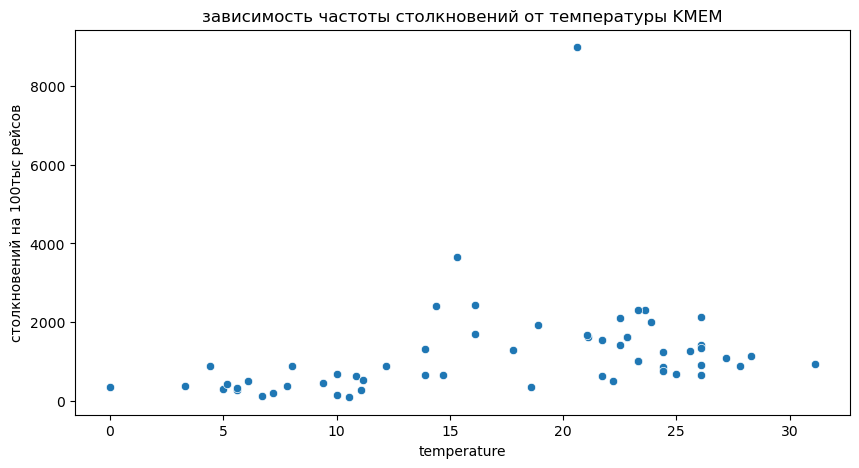

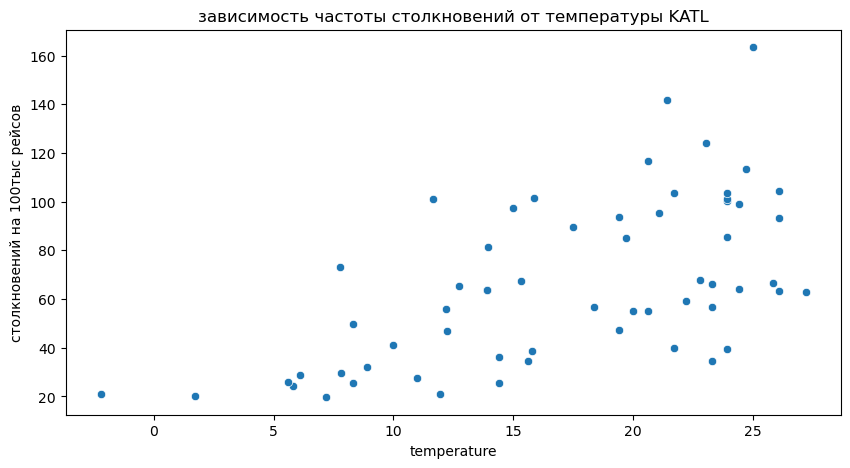

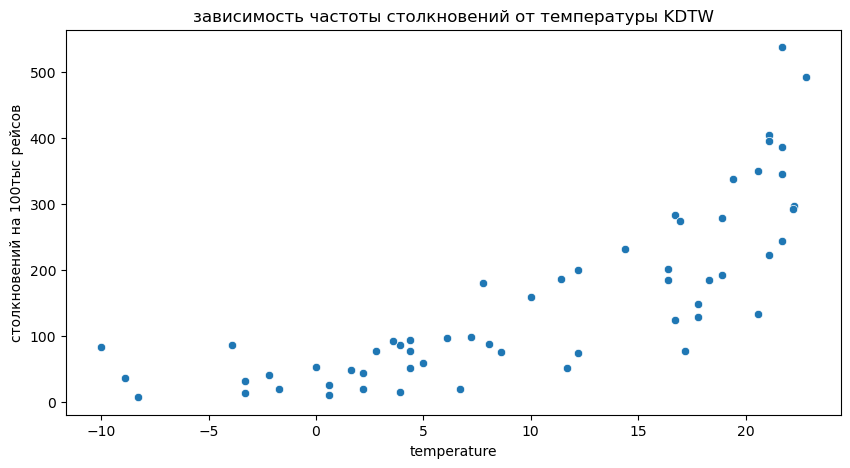

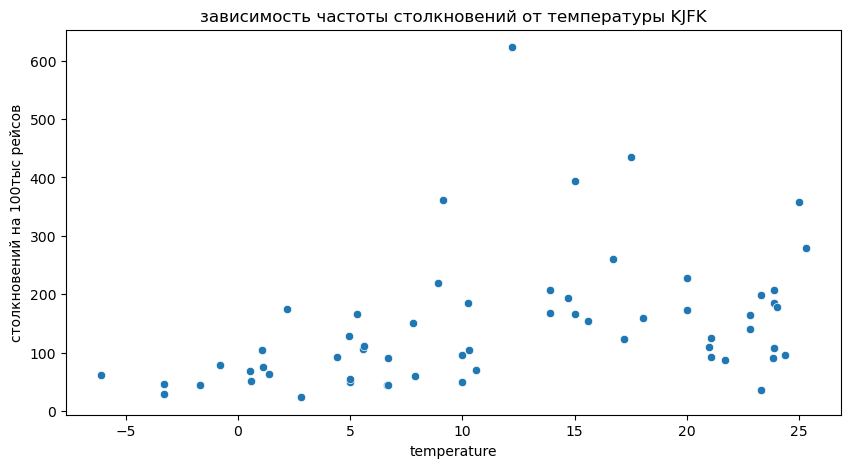

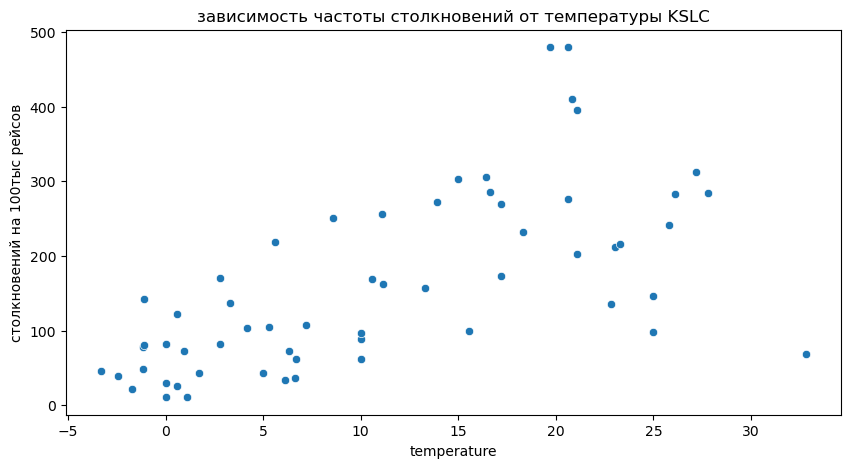

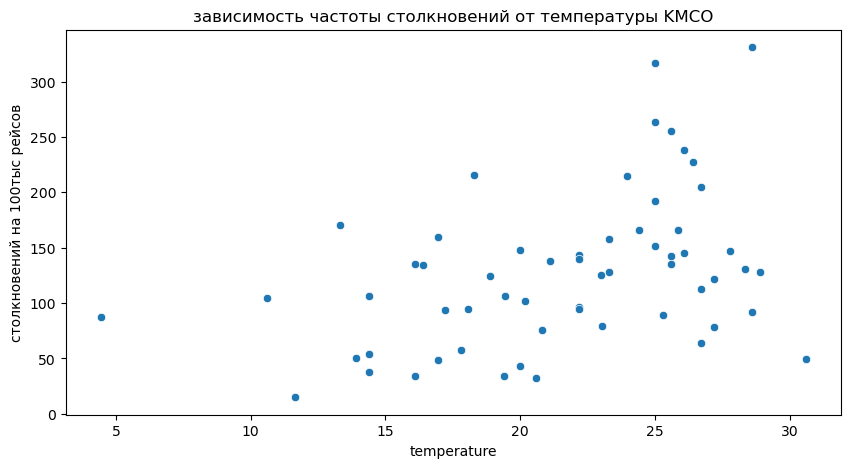

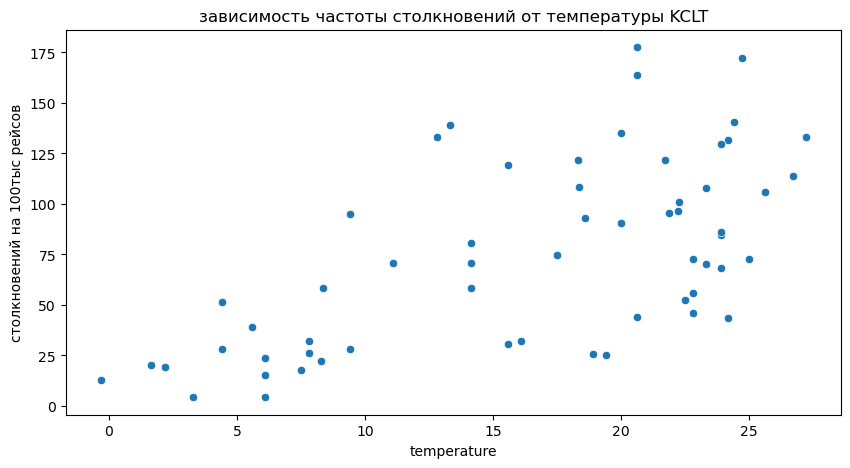

In [45]:
## построим диаграмму рассеяния: зависимость частоты столкновений от температуры для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="temperature", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от температуры ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

Видна зависимость количества столкновений от температуры воздуха, это очевидно - мы уже видели зависимость от времени года, в теплое время года столкновений больше. (увидим ли мы эту зависимость ограничив выборку конкретными месяцами и достаточно ли будет данных?)

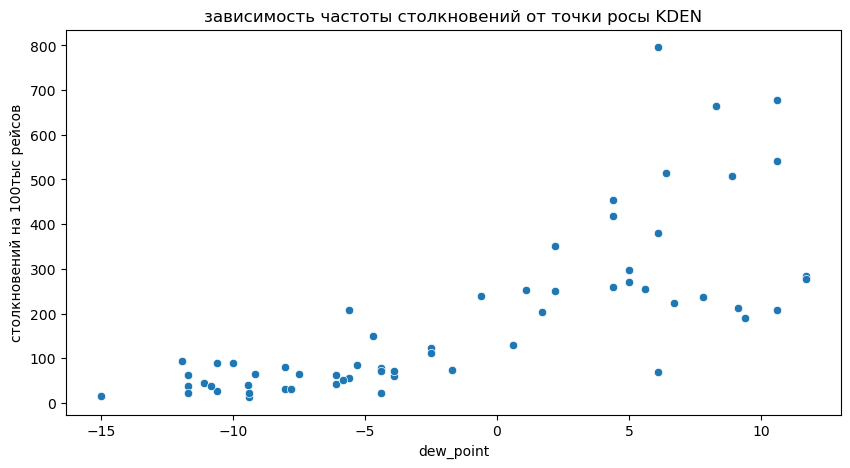

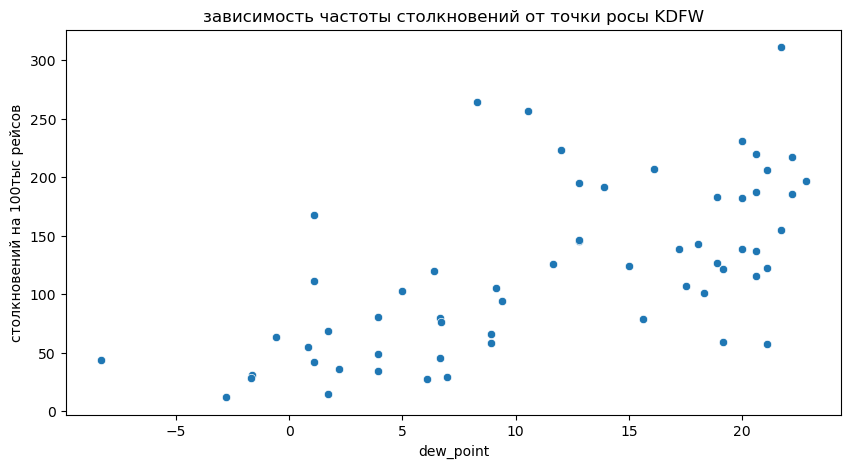

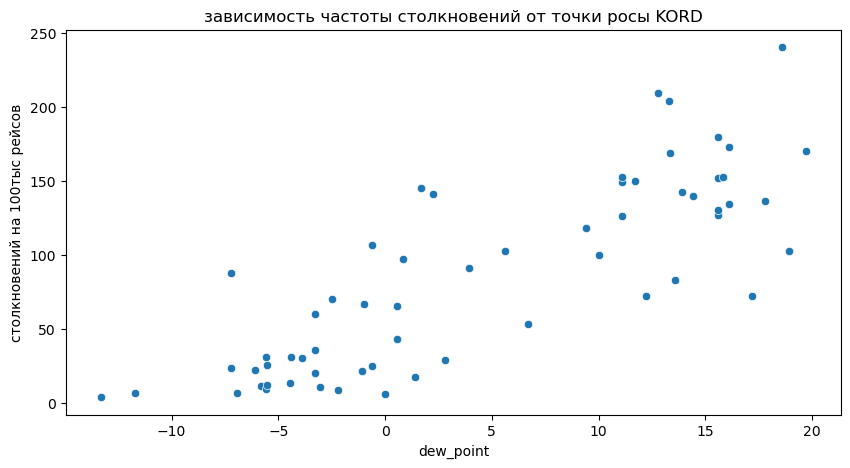

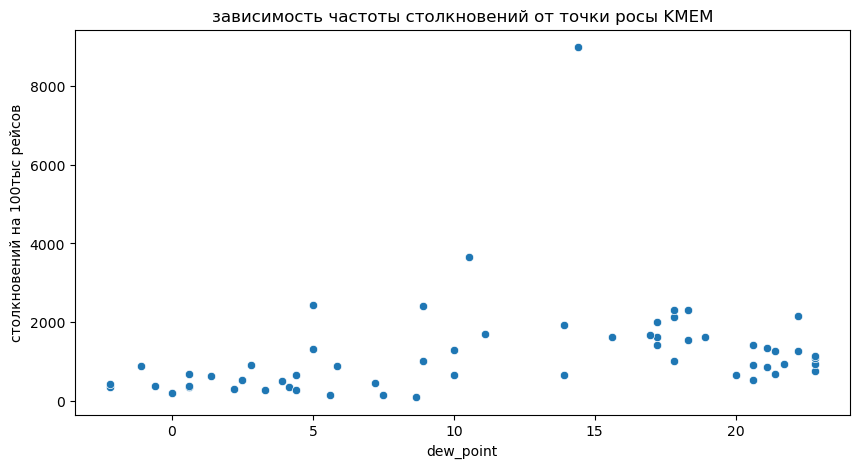

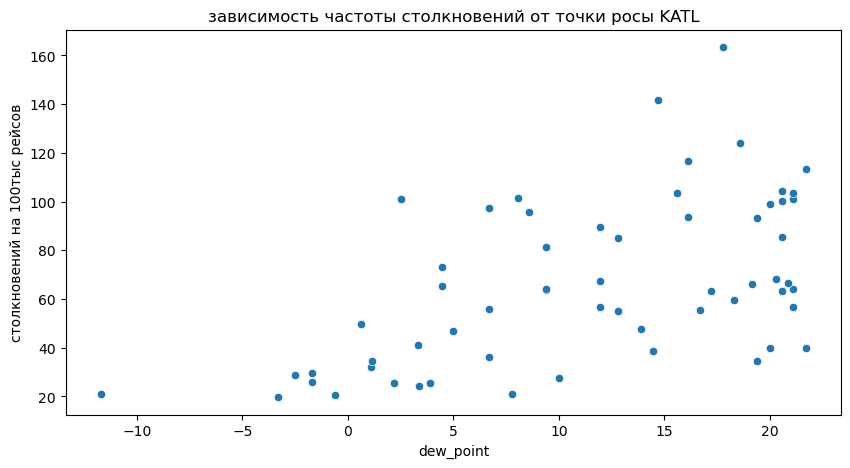

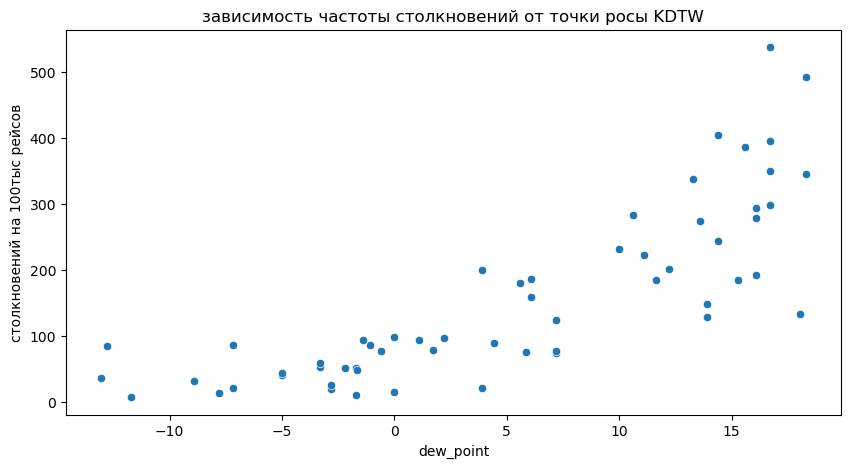

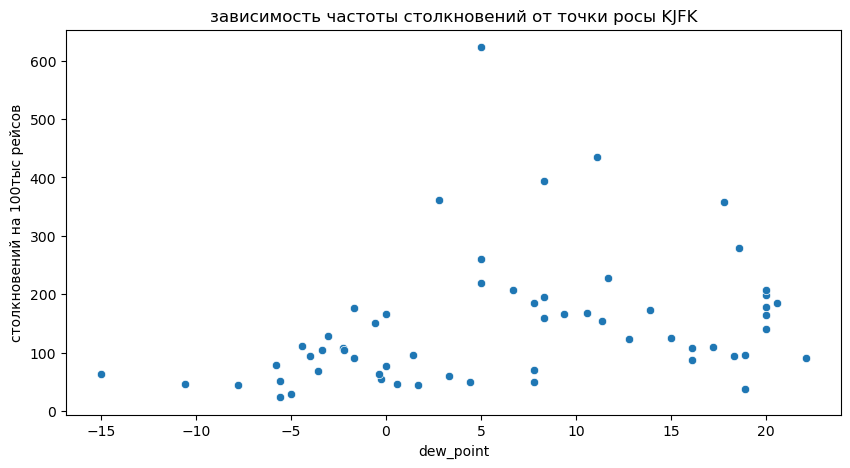

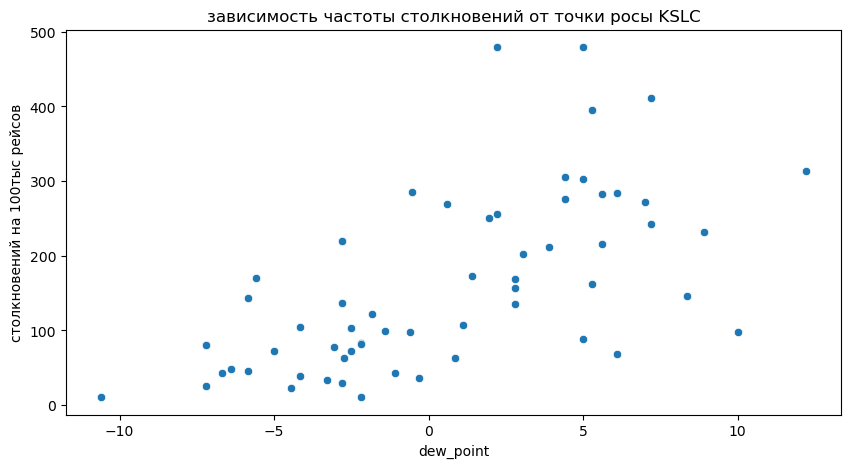

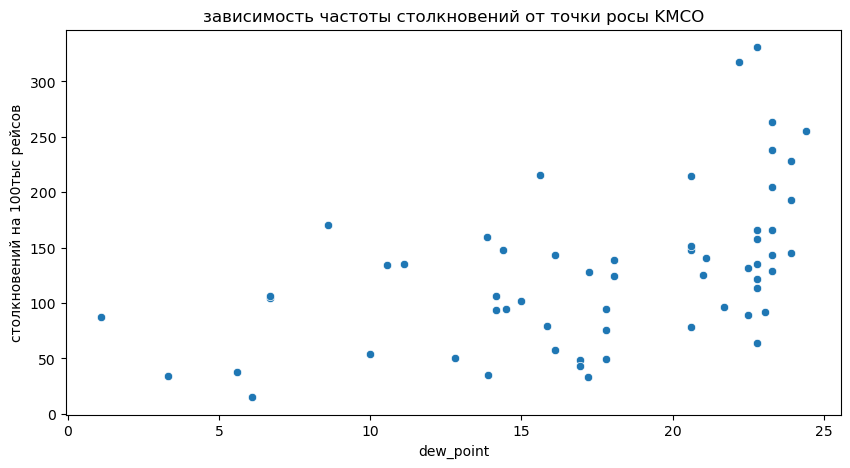

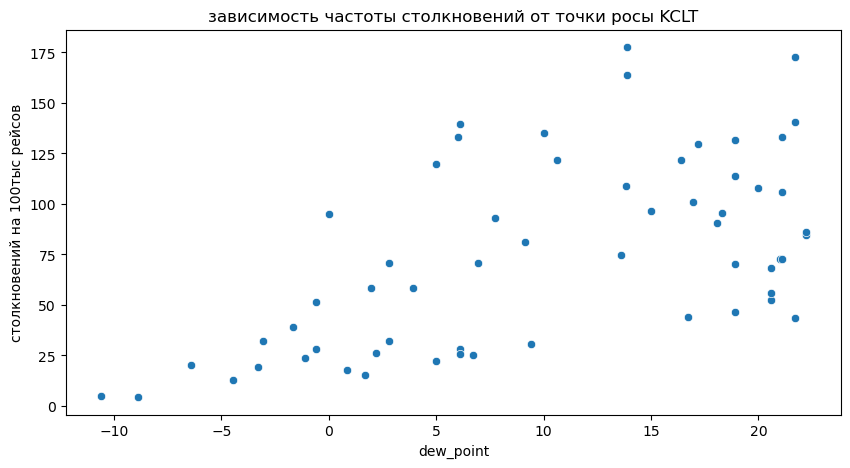

In [46]:
## построим диаграмму рассеяния: зависимость частоты столкновений от точки росы для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="dew_point", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от точки росы ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

от точки росы мы видим ту же зависимость, что и от температуры

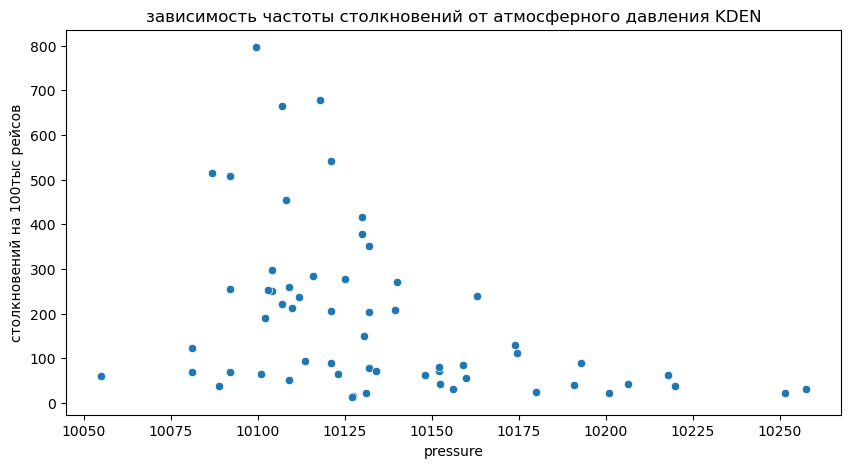

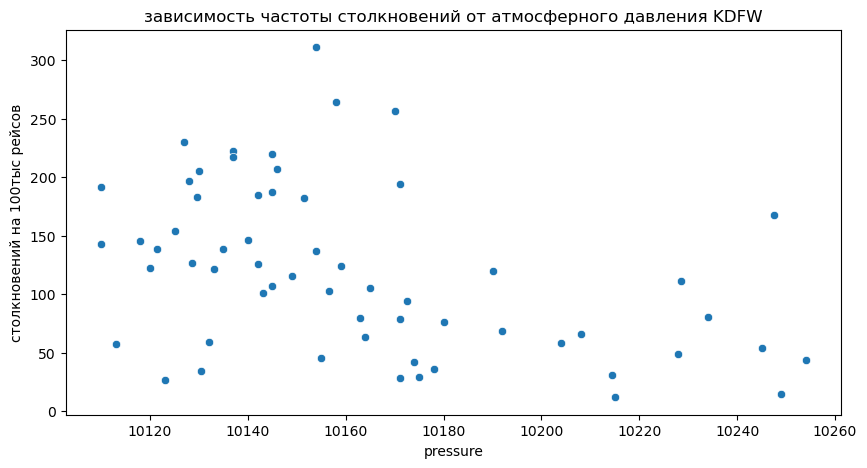

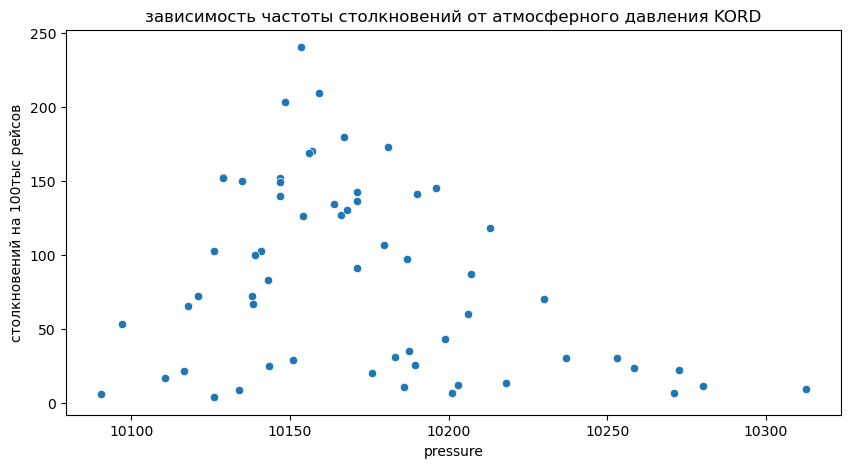

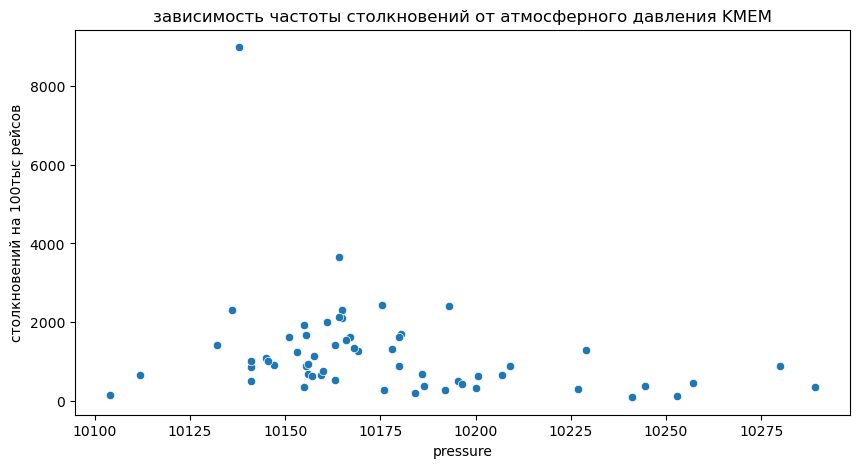

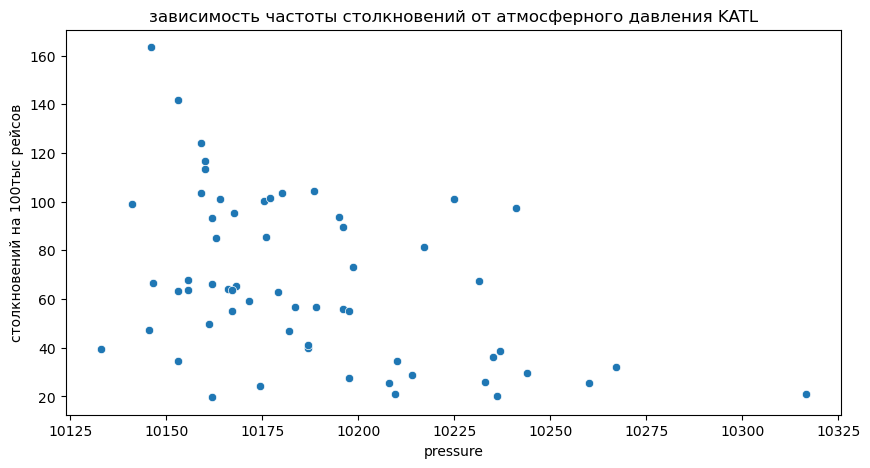

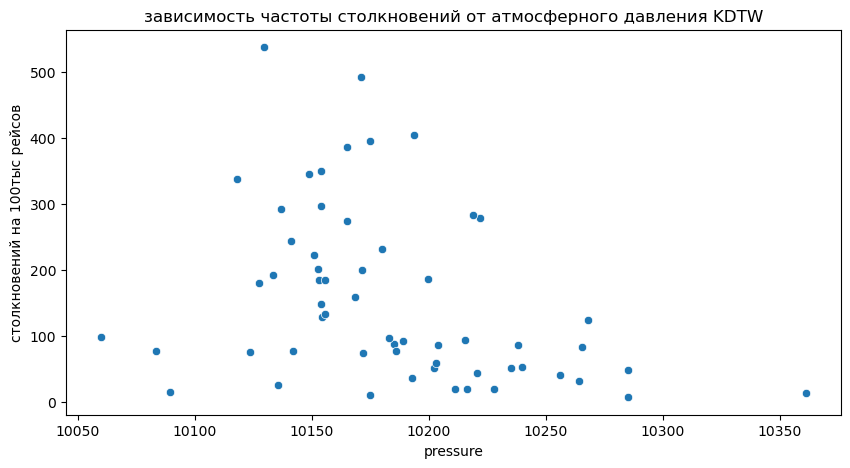

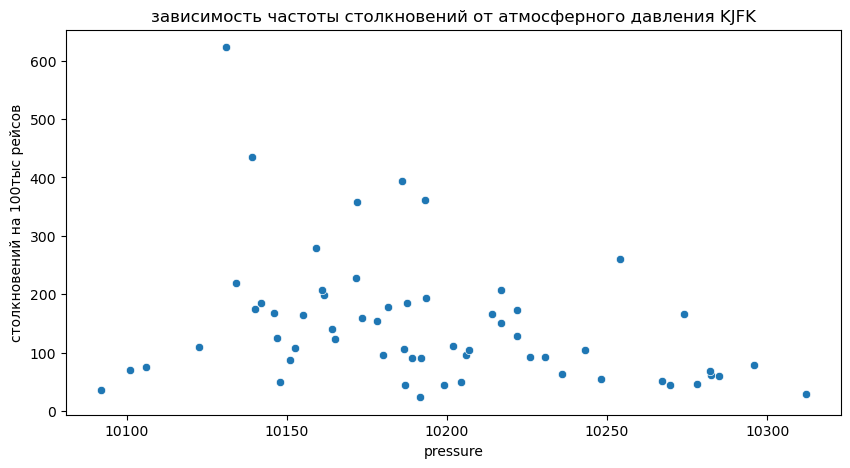

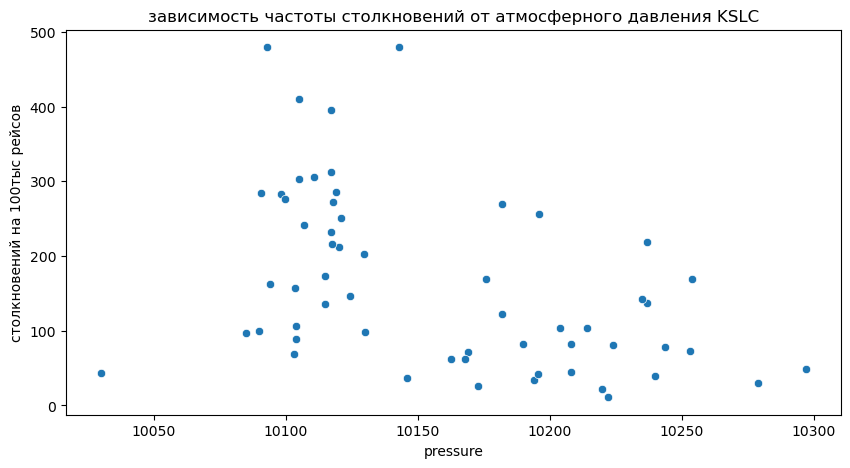

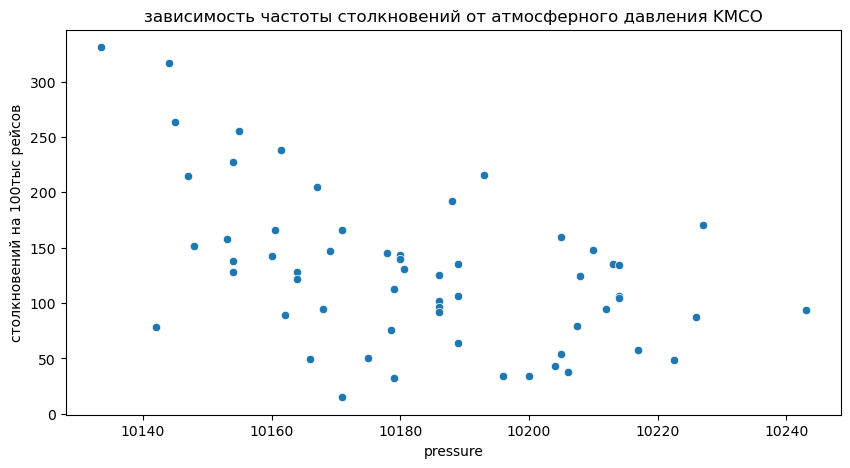

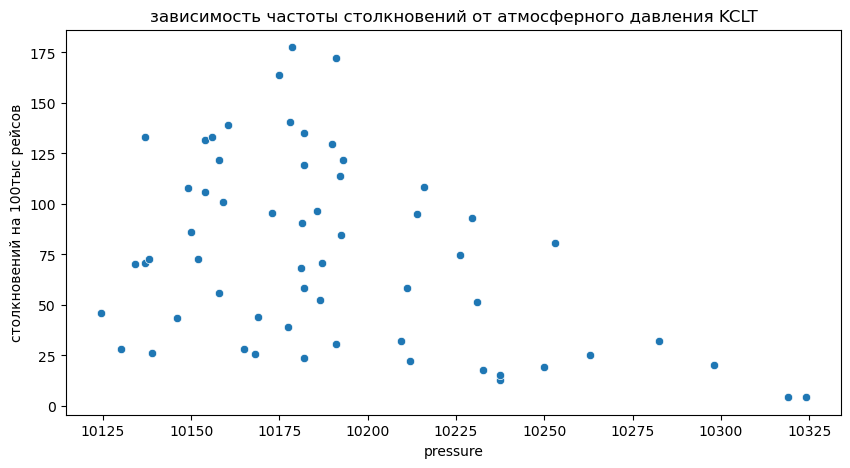

In [47]:
## построим диаграмму рассеяния: зависимость частоты столкновений от атмосферного давления для каждого аэропорта
for airport in top_10_list:
    plt.figure(figsize=[10, 5])
    sns.scatterplot(data=top_airports[top_airports['airport_id'] == airport], x="pressure", y="strikes_by_100000")
    plt.title('зависимость частоты столкновений от атмосферного давления ' + airport)
    plt.ylabel('столкновений на 100тыс рейсов')
    plt.show()

Наблюдается обратная линейная зависимость от атмосферного давления - с ростом давления количество столкновений падает

На диаграммах рассеяния мы увидели линейную зависимость относительного количества столкновений от вертикальной видимости при изменениях до 5000, от температуры и точки росы и обратную линейную зависимость от атмосферного давления.

In [48]:
# список погодных измерений
observations = ['wind_speed','vertical_visibility','horizontal_visibility','temperature','dew_point','pressure']   

In [49]:
# для каждого погодного фактора, для каждого аэропорта и для каждого месяца вычислим коэффициент корреляции Пирсона
# выведем те, которые указывают на сильную связь
for observation in observations:
    print(observation)
    for airport in top_10_list:
        test_slice = top_airports[(top_airports['airport_id'] == airport)]
        print(airport, test_slice['strikes_by_100000'].corr(test_slice[observation]).round(2))
    print()

wind_speed
KDEN 0.13
KDFW -0.18
KORD -0.29
KMEM 0.01
KATL -0.24
KDTW -0.34
KJFK 0.04
KSLC 0.03
KMCO -0.22
KCLT 0.07

vertical_visibility
KDEN 0.18
KDFW 0.11
KORD 0.25
KMEM 0.06
KATL 0.13
KDTW 0.17
KJFK 0.05
KSLC 0.44
KMCO 0.02
KCLT 0.26

horizontal_visibility
KDEN 0.11
KDFW 0.18
KORD 0.25
KMEM 0.15
KATL 0.07
KDTW 0.02
KJFK 0.15
KSLC 0.29
KMCO 0.14
KCLT 0.08

temperature
KDEN 0.74
KDFW 0.59
KORD 0.84
KMEM 0.31
KATL 0.61
KDTW 0.8
KJFK 0.38
KSLC 0.64
KMCO 0.41
KCLT 0.63

dew_point
KDEN 0.75
KDFW 0.63
KORD 0.82
KMEM 0.28
KATL 0.54
KDTW 0.81
KJFK 0.3
KSLC 0.62
KMCO 0.5
KCLT 0.58

pressure
KDEN -0.4
KDFW -0.43
KORD -0.3
KMEM -0.28
KATL -0.45
KDTW -0.35
KJFK -0.32
KSLC -0.45
KMCO -0.49
KCLT -0.41



Коэффициенты кореляции Пирсона подтверждают наши выводы при рассмотрении диаграмм рассеивания - есть небольшая зависимость от вертикальной видимости, от температуры и точки росы, обратная зависимость от атмосферного давления.

In [50]:
# коэффициенты корреляции для вертикальной видимости до 10тыс метров
for airport in top_10_list:
    test_slice = top_airports[(top_airports['airport_id'] == airport) & (top_airports['vertical_visibility'] <= 10000)]
    print(airport, test_slice['strikes_by_100000'].corr(test_slice['vertical_visibility']).round(2))

KDEN 0.48
KDFW 0.25
KORD 0.4
KMEM 0.28
KATL 0.51
KDTW 0.63
KJFK 0.06
KSLC 0.49
KMCO 0.46
KCLT 0.65


Пока мы не увидели четкой зависимости от погоды, а нашли только сезонную зависимость. 

## Подробное изучение некоторых выборок

Найдем коэффициенты корреляции Пирсона совокупностей (погодный фактор + аэропорт + месяц) с относительным количеством столкновений

In [51]:
# для каждого погодного фактора, для каждого аэропорта и для каждого месяца вычислим коэффициент корреляции Пирсона
# выведем те, которые указывают на сильную связь
for observation in observations:
    print(observation)
    for airport in top_10_list:
        for month in range(1, 13):
            test_slice = top_airports[(top_airports['airport_id'] == airport) & (top_airports['month'] == month)]
            if (test_slice['strikes_by_100000'].corr(test_slice[observation])) > 0.8 or (test_slice['strikes_by_100000'].corr(test_slice[observation])) < -0.8:
                print(airport, 'месяц:', month, test_slice['strikes_by_100000'].corr(test_slice[observation]).round(2))
    print()

wind_speed
KDEN месяц: 6 0.91
KDEN месяц: 7 -0.82
KDEN месяц: 12 0.83
KDFW месяц: 1 0.96
KDFW месяц: 10 0.89
KORD месяц: 6 -0.92
KMEM месяц: 3 0.83
KATL месяц: 3 -0.93
KDTW месяц: 3 -0.82
KJFK месяц: 3 0.84
KJFK месяц: 4 0.93
KMCO месяц: 2 0.86
KCLT месяц: 2 0.89

vertical_visibility
KDEN месяц: 11 0.95
KDFW месяц: 3 -0.84
KDFW месяц: 11 -0.82
KORD месяц: 2 -0.94
KORD месяц: 4 -0.82
KORD месяц: 7 -0.98
KMEM месяц: 1 0.86
KATL месяц: 3 -0.97
KDTW месяц: 11 0.91
KJFK месяц: 5 -0.85
KSLC месяц: 2 0.87
KSLC месяц: 4 -0.81
KMCO месяц: 1 0.84

horizontal_visibility
KORD месяц: 4 0.83
KORD месяц: 8 0.82
KATL месяц: 5 0.96
KDTW месяц: 4 0.81
KDTW месяц: 12 -0.9
KJFK месяц: 8 0.84
KSLC месяц: 2 0.81
KSLC месяц: 8 -0.85
KCLT месяц: 3 0.85
KCLT месяц: 4 0.97
KCLT месяц: 5 0.87
KCLT месяц: 6 -0.88

temperature
KDEN месяц: 1 -0.84
KDEN месяц: 7 0.91
KDEN месяц: 8 0.9
KDEN месяц: 9 -0.98
KDFW месяц: 10 -0.82
KORD месяц: 2 0.92
KORD месяц: 5 0.92
KMEM месяц: 1 -0.95
KATL месяц: 4 -0.88
KDTW месяц: 2 

В одних и тех же аэропортах в разные месяцы коэффициенты корреляции демонстрируют порой противоположную зависимость количества столкновений от погодных факторов - это связано со слишком малой выборкой, сравниваются всего 5 пар чисел. К сожалению, если отбросить все различия кроме погодных, данных остается слишком мало.

## 4 аэропорта со схожими аномалиями

В мае 2020 года наблюдалось максимальное аномальное количество столкновений с птицами в аэропорту KMEM, аналогичные всплески наблюдались в некоторых других аэропортах, посмотрим как менялись показатели в эти месяцы в разные годы.

In [52]:
top_airports[(top_airports['airport_id'] == 'KMEM') & (top_airports['month'] == 5)]

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
244,KMEM,2018,5,2018-05-01,2271,48,2113.6,3.10,22000.0,16093.0,22.5,17.8,10165.0
256,KMEM,2019,5,2019-05-01,2601,26,999.6,3.60,22000.0,16093.0,23.3,17.8,10141.0
268,KMEM,2020,5,2020-05-01,601,54,8985.0,3.10,7620.0,16093.0,20.6,14.4,10138.0
280,KMEM,2021,5,2021-05-01,1781,29,1628.3,3.60,7620.0,16093.0,21.1,15.6,10180.0
292,KMEM,2022,5,2022-05-01,1971,28,1420.6,4.35,7620.0,16093.0,22.5,17.2,10132.0


In [53]:
top_airports[(top_airports['airport_id'] == 'KDEN') & (top_airports['month'] == 6)]

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
5,KDEN,2018,6,2018-06-01,25214,130,515.6,4.6,22000.0,16000.0,16.1,6.4,10087.0
17,KDEN,2019,6,2019-06-01,26555,63,237.2,4.1,22000.0,16093.0,14.4,7.8,10112.0
29,KDEN,2020,6,2020-06-01,11176,89,796.3,5.1,22000.0,16093.0,17.2,6.1,10099.5
41,KDEN,2021,6,2021-06-01,25200,128,507.9,4.6,22000.0,16093.0,19.4,8.9,10092.0
53,KDEN,2022,6,2022-06-01,25296,115,454.6,4.1,22000.0,16093.0,18.9,4.4,10108.0


In [54]:
top_airports[(top_airports['airport_id'] == 'KJFK') & (top_airports['month'] == 6)]

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
365,KJFK,2018,6,2018-06-01,18967,7,36.9,5.1,8230.0,16000.0,23.3,18.9,10092.0
377,KJFK,2019,6,2019-06-01,18381,23,125.1,4.1,22000.0,16093.0,21.1,15.0,10147.0
389,KJFK,2020,6,2020-06-01,2519,9,357.3,6.2,7620.0,16093.0,25.0,17.8,10172.0
401,KJFK,2021,6,2021-06-01,11869,13,109.5,4.6,6096.0,16093.0,21.0,17.2,10122.5
413,KJFK,2022,6,2022-06-01,17212,15,87.1,4.1,6248.5,16093.0,21.7,16.1,10151.0


In [55]:
top_airports[(top_airports['airport_id'] == 'KORD') & (top_airports['month'] == 6)]

,airport_id,year,month,date,flights,strikes,strikes_by_100000,wind_speed,vertical_visibility,horizontal_visibility,temperature,dew_point,pressure
125,KORD,2018,6,2018-06-01,37369,27,72.3,3.6,7620.0,16000.0,21.1,17.2,10138.0
137,KORD,2019,6,2019-06-01,38385,32,83.4,3.1,7620.0,16093.0,18.6,13.6,10143.0
149,KORD,2020,6,2020-06-01,9547,20,209.5,2.1,22000.0,16093.0,18.9,12.8,10159.0
161,KORD,2021,6,2021-06-01,28996,21,72.4,3.6,22000.0,16093.0,22.2,12.2,10121.0
173,KORD,2022,6,2022-06-01,28671,43,150.0,3.1,22000.0,16093.0,20.6,11.7,10135.0


В 2020 году количество столкновений почти не снизилось, при этом количесто рейсов сократилось в разы. Снижение количества рейсов связано с эпидемией COVID-19

## Формулировка гипотезы

Эпидемия COVID-19 привела к снижению количества рейсов, из-за этого летом 2020 года во многих аэропортах из-за снижения уровня шума птицы стали гнездиться ближе к аэропорту, поэтому в некоторых аэропортах в начале лета был зафиксирован рост количества столкновений с птицами относительно количества рейсов. Вероятно, это оказало меньшее влияние на столкновения при осенней миграции, и имеет отношение не ко всем видам птиц.

In [56]:
# вычислим коэффициенты корреляции Пирсона для летних месяцев между количеством рейсов и относительным количеством столкновений
summer = [5,6,7]
airport = 'KMEM'
test_slice = top_airports.query('month in @summer')


for airport in top_10_list:
    test_slice = top_airports.query('month in @summer')
    test_slice = test_slice[test_slice['airport_id'] == airport]
    
    print(airport, test_slice['flights'].corr(test_slice['strikes_by_100000']))

KDEN -0.4082812731176906
KDFW -0.009949058286424872
KORD -0.5059320262920952
KMEM -0.6786199605367775
KATL -0.5879669339708934
KDTW 0.01901481713855963
KJFK -0.8387145399685635
KSLC -0.4576887718690368
KMCO 0.2291709445809935
KCLT -0.05057390598416065


В большинстве аэропортов мы видим отрицательную линейную зависимость.

In [57]:
# коэффициент корреляции Пирсона для 10 аэропортов без разбивки на месяцы
print(top_airports['flights'].corr(top_airports['strikes_by_100000']))

-0.3718758085259218


## Выводы и результаты

- большинство столкновений происходит в тепло время года, но распределение столкновений различно в зависимости от аэропорта
- большинство столкновений происходит в утренние часы, но есть аэропорты, где столкновения более вероятны вечером
- мы не нашли зависимости от погоды, кроме очевидных сезонных всплеском связанных с активностью птиц: миграцией и рождением птенцов
- каждый аэропорт имеет свои уникальные характеристики, поэтому выводы по одному аэропорту нельзя перенести на другой аэропорт, детальный анализ каждого аэропорта требует больше данных
- для анализа влияния погоды в течение одного года/сезона необходимо иметь данные обо всех рейсах и о погоде за каждый день
- выдвинута гипотеза о связи между количеством рейсов и относительным количеством столкновений с птицами, эта связь нуждается в проверке